# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

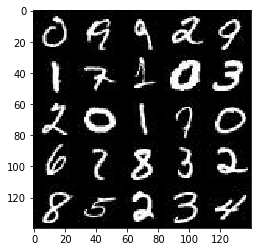

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

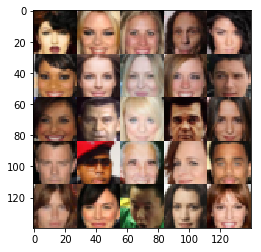

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_images"), tf.placeholder(tf.float32, (None, z_dim), name="z_data"), tf.placeholder(
        tf.float32, None, name="learning_rate")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/facegen/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/facegen/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/facegen/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/facegen/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/facegen/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/hom

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.dropout(x, 0.8)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.dropout(x, 0.8)
        x = tf.maximum(alpha * x, x)
        
        # flaten
        flat = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.dropout(x, 0.8)
        x = tf.maximum(alpha * x, x)
#         print(x.get_shape())
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.dropout(x, 0.8)
        x = tf.maximum(alpha * x, x)
#         print(x.get_shape())
            
        x = tf.contrib.layers.conv2d_transpose(x, 128, 5, stride=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
#         print(x.get_shape())
        
        # out
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
#         print(out.get_shape())
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    steps = 0   
    
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                #sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 0.5717... Generator Loss: 2.0703
Epoch 1/3... Discriminator Loss: 0.6913... Generator Loss: 1.6815
Epoch 1/3... Discriminator Loss: 0.8835... Generator Loss: 1.2775
Epoch 1/3... Discriminator Loss: 0.9212... Generator Loss: 1.4848
Epoch 1/3... Discriminator Loss: 0.7547... Generator Loss: 1.5547
Epoch 1/3... Discriminator Loss: 0.5027... Generator Loss: 3.1526
Epoch 1/3... Discriminator Loss: 0.4447... Generator Loss: 3.0821
Epoch 1/3... Discriminator Loss: 0.6170... Generator Loss: 4.5773
Epoch 1/3... Discriminator Loss: 0.7114... Generator Loss: 3.0118
Epoch 1/3... Discriminator Loss: 0.9646... Generator Loss: 1.2576


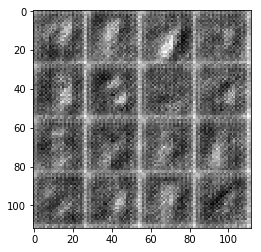

Epoch 1/3... Discriminator Loss: 0.9811... Generator Loss: 1.3989
Epoch 1/3... Discriminator Loss: 0.7666... Generator Loss: 1.5465
Epoch 1/3... Discriminator Loss: 0.8239... Generator Loss: 1.5853
Epoch 1/3... Discriminator Loss: 0.9189... Generator Loss: 2.2334
Epoch 1/3... Discriminator Loss: 0.8284... Generator Loss: 2.2129
Epoch 1/3... Discriminator Loss: 0.8671... Generator Loss: 1.4066
Epoch 1/3... Discriminator Loss: 0.9908... Generator Loss: 2.1417
Epoch 1/3... Discriminator Loss: 1.0753... Generator Loss: 2.1424
Epoch 1/3... Discriminator Loss: 1.0129... Generator Loss: 1.7934
Epoch 1/3... Discriminator Loss: 0.9058... Generator Loss: 1.3135


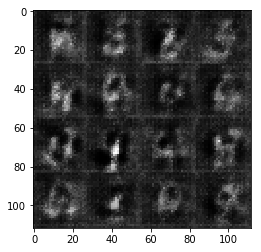

Epoch 1/3... Discriminator Loss: 0.7781... Generator Loss: 1.7903
Epoch 1/3... Discriminator Loss: 0.9708... Generator Loss: 1.6862
Epoch 1/3... Discriminator Loss: 0.9831... Generator Loss: 2.3422
Epoch 1/3... Discriminator Loss: 0.9401... Generator Loss: 1.8320
Epoch 1/3... Discriminator Loss: 0.9840... Generator Loss: 2.4269
Epoch 1/3... Discriminator Loss: 0.9368... Generator Loss: 1.6882
Epoch 1/3... Discriminator Loss: 0.8596... Generator Loss: 1.7278
Epoch 1/3... Discriminator Loss: 0.8623... Generator Loss: 1.6638
Epoch 1/3... Discriminator Loss: 0.8672... Generator Loss: 1.8022
Epoch 1/3... Discriminator Loss: 0.9633... Generator Loss: 2.3090


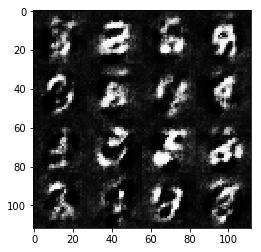

Epoch 1/3... Discriminator Loss: 1.0607... Generator Loss: 2.0905
Epoch 1/3... Discriminator Loss: 0.9270... Generator Loss: 1.7622
Epoch 1/3... Discriminator Loss: 0.8941... Generator Loss: 1.8178
Epoch 1/3... Discriminator Loss: 0.8623... Generator Loss: 2.1640
Epoch 1/3... Discriminator Loss: 0.7996... Generator Loss: 1.6162
Epoch 1/3... Discriminator Loss: 0.8275... Generator Loss: 1.7400
Epoch 1/3... Discriminator Loss: 1.1087... Generator Loss: 1.0048
Epoch 1/3... Discriminator Loss: 0.7821... Generator Loss: 1.9339
Epoch 1/3... Discriminator Loss: 0.8379... Generator Loss: 1.6575
Epoch 1/3... Discriminator Loss: 0.8849... Generator Loss: 1.5144


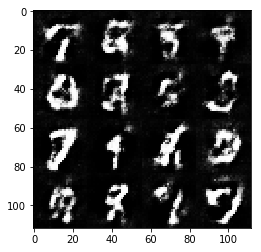

Epoch 1/3... Discriminator Loss: 0.9593... Generator Loss: 1.2109
Epoch 1/3... Discriminator Loss: 0.9974... Generator Loss: 1.0725
Epoch 1/3... Discriminator Loss: 0.8876... Generator Loss: 2.1125
Epoch 1/3... Discriminator Loss: 0.9217... Generator Loss: 1.4145
Epoch 1/3... Discriminator Loss: 0.8452... Generator Loss: 1.9727
Epoch 1/3... Discriminator Loss: 0.8146... Generator Loss: 1.9597
Epoch 1/3... Discriminator Loss: 0.9020... Generator Loss: 2.3947
Epoch 1/3... Discriminator Loss: 0.9086... Generator Loss: 1.3741
Epoch 1/3... Discriminator Loss: 0.9202... Generator Loss: 1.3804
Epoch 1/3... Discriminator Loss: 1.0919... Generator Loss: 0.8188


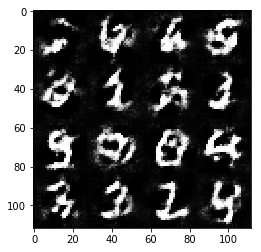

Epoch 1/3... Discriminator Loss: 0.8854... Generator Loss: 1.6583
Epoch 1/3... Discriminator Loss: 0.9587... Generator Loss: 1.7879
Epoch 1/3... Discriminator Loss: 1.0254... Generator Loss: 1.2629
Epoch 1/3... Discriminator Loss: 0.8899... Generator Loss: 1.8443
Epoch 1/3... Discriminator Loss: 0.9025... Generator Loss: 1.6396
Epoch 1/3... Discriminator Loss: 1.1379... Generator Loss: 1.4487
Epoch 1/3... Discriminator Loss: 0.9640... Generator Loss: 1.8062
Epoch 1/3... Discriminator Loss: 1.0477... Generator Loss: 0.9965
Epoch 1/3... Discriminator Loss: 1.1297... Generator Loss: 0.8170
Epoch 1/3... Discriminator Loss: 1.1355... Generator Loss: 2.0909


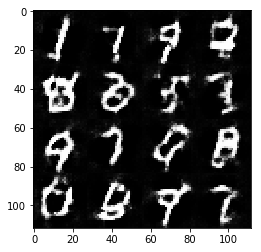

Epoch 1/3... Discriminator Loss: 0.8856... Generator Loss: 1.5014
Epoch 1/3... Discriminator Loss: 1.0284... Generator Loss: 1.4927
Epoch 1/3... Discriminator Loss: 1.0064... Generator Loss: 2.1967
Epoch 1/3... Discriminator Loss: 0.9730... Generator Loss: 1.0574
Epoch 1/3... Discriminator Loss: 1.0998... Generator Loss: 0.9408
Epoch 1/3... Discriminator Loss: 1.0536... Generator Loss: 2.2604
Epoch 1/3... Discriminator Loss: 0.8938... Generator Loss: 1.3144
Epoch 1/3... Discriminator Loss: 1.0938... Generator Loss: 1.8516
Epoch 1/3... Discriminator Loss: 0.9894... Generator Loss: 1.2987
Epoch 1/3... Discriminator Loss: 1.0686... Generator Loss: 1.1105


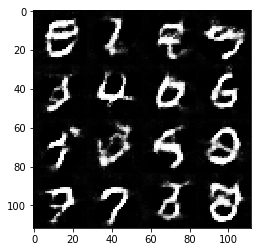

Epoch 1/3... Discriminator Loss: 1.0240... Generator Loss: 1.3403
Epoch 1/3... Discriminator Loss: 1.3066... Generator Loss: 0.7234
Epoch 1/3... Discriminator Loss: 1.0898... Generator Loss: 1.7272
Epoch 1/3... Discriminator Loss: 0.9258... Generator Loss: 1.7052
Epoch 1/3... Discriminator Loss: 1.1318... Generator Loss: 1.1356
Epoch 1/3... Discriminator Loss: 1.1784... Generator Loss: 1.5139
Epoch 1/3... Discriminator Loss: 1.0487... Generator Loss: 1.0396
Epoch 1/3... Discriminator Loss: 1.0441... Generator Loss: 1.0719
Epoch 1/3... Discriminator Loss: 1.0059... Generator Loss: 1.4905
Epoch 1/3... Discriminator Loss: 0.9686... Generator Loss: 1.2840


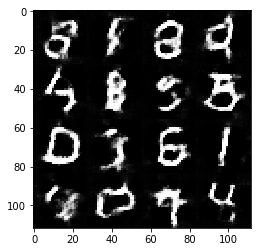

Epoch 1/3... Discriminator Loss: 0.9873... Generator Loss: 1.9831
Epoch 1/3... Discriminator Loss: 1.0897... Generator Loss: 1.8003
Epoch 1/3... Discriminator Loss: 1.0014... Generator Loss: 2.1372
Epoch 1/3... Discriminator Loss: 1.1367... Generator Loss: 1.6516
Epoch 1/3... Discriminator Loss: 1.0152... Generator Loss: 1.4233
Epoch 1/3... Discriminator Loss: 0.9114... Generator Loss: 1.3039
Epoch 1/3... Discriminator Loss: 0.9183... Generator Loss: 1.4983
Epoch 1/3... Discriminator Loss: 1.0128... Generator Loss: 1.5923
Epoch 1/3... Discriminator Loss: 1.0992... Generator Loss: 0.8117
Epoch 1/3... Discriminator Loss: 1.0673... Generator Loss: 1.1358


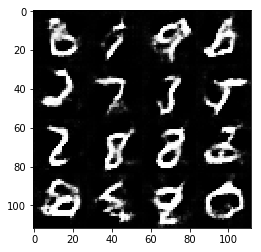

Epoch 1/3... Discriminator Loss: 0.9333... Generator Loss: 1.4501
Epoch 1/3... Discriminator Loss: 1.1285... Generator Loss: 2.0877
Epoch 1/3... Discriminator Loss: 1.1139... Generator Loss: 1.7146
Epoch 2/3... Discriminator Loss: 1.0134... Generator Loss: 1.2632
Epoch 2/3... Discriminator Loss: 1.0304... Generator Loss: 1.1749
Epoch 2/3... Discriminator Loss: 1.0617... Generator Loss: 1.5985
Epoch 2/3... Discriminator Loss: 1.0019... Generator Loss: 1.8854
Epoch 2/3... Discriminator Loss: 1.0146... Generator Loss: 1.4176
Epoch 2/3... Discriminator Loss: 1.0179... Generator Loss: 1.2421
Epoch 2/3... Discriminator Loss: 1.2485... Generator Loss: 0.7112


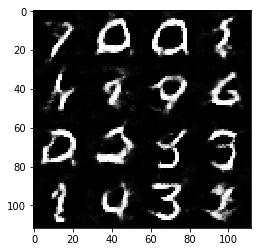

Epoch 2/3... Discriminator Loss: 1.1539... Generator Loss: 0.9783
Epoch 2/3... Discriminator Loss: 1.0258... Generator Loss: 1.6336
Epoch 2/3... Discriminator Loss: 0.9424... Generator Loss: 1.3821
Epoch 2/3... Discriminator Loss: 1.0351... Generator Loss: 1.1632
Epoch 2/3... Discriminator Loss: 1.0295... Generator Loss: 1.0620
Epoch 2/3... Discriminator Loss: 1.1271... Generator Loss: 1.4290
Epoch 2/3... Discriminator Loss: 1.0083... Generator Loss: 1.2087
Epoch 2/3... Discriminator Loss: 1.0535... Generator Loss: 1.7870
Epoch 2/3... Discriminator Loss: 0.9022... Generator Loss: 1.5682
Epoch 2/3... Discriminator Loss: 1.0786... Generator Loss: 1.4471


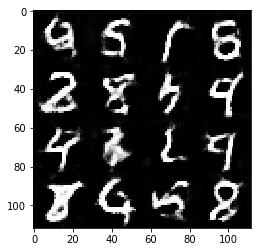

Epoch 2/3... Discriminator Loss: 1.1035... Generator Loss: 1.4137
Epoch 2/3... Discriminator Loss: 1.0442... Generator Loss: 1.7454
Epoch 2/3... Discriminator Loss: 0.9866... Generator Loss: 1.6255
Epoch 2/3... Discriminator Loss: 1.3223... Generator Loss: 0.8624
Epoch 2/3... Discriminator Loss: 0.9270... Generator Loss: 1.3577
Epoch 2/3... Discriminator Loss: 1.0309... Generator Loss: 1.3284
Epoch 2/3... Discriminator Loss: 1.1269... Generator Loss: 2.1038
Epoch 2/3... Discriminator Loss: 1.1247... Generator Loss: 1.0127
Epoch 2/3... Discriminator Loss: 0.9346... Generator Loss: 1.6068
Epoch 2/3... Discriminator Loss: 1.0253... Generator Loss: 1.2657


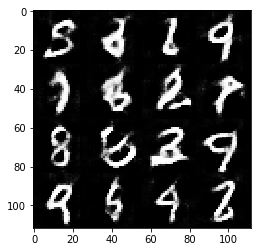

Epoch 2/3... Discriminator Loss: 0.9095... Generator Loss: 1.5023
Epoch 2/3... Discriminator Loss: 1.0814... Generator Loss: 1.4850
Epoch 2/3... Discriminator Loss: 1.2016... Generator Loss: 0.8671
Epoch 2/3... Discriminator Loss: 0.9524... Generator Loss: 1.3267
Epoch 2/3... Discriminator Loss: 1.0722... Generator Loss: 1.3869
Epoch 2/3... Discriminator Loss: 1.0007... Generator Loss: 1.3399
Epoch 2/3... Discriminator Loss: 1.3794... Generator Loss: 2.0980
Epoch 2/3... Discriminator Loss: 1.0404... Generator Loss: 1.2503
Epoch 2/3... Discriminator Loss: 0.9083... Generator Loss: 1.7022
Epoch 2/3... Discriminator Loss: 0.9606... Generator Loss: 1.6566


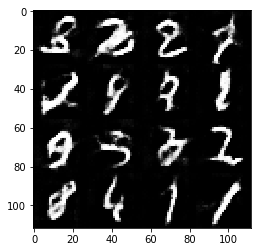

Epoch 2/3... Discriminator Loss: 1.0107... Generator Loss: 1.6176
Epoch 2/3... Discriminator Loss: 1.0447... Generator Loss: 1.2529
Epoch 2/3... Discriminator Loss: 0.9943... Generator Loss: 1.2485
Epoch 2/3... Discriminator Loss: 1.0857... Generator Loss: 0.9022
Epoch 2/3... Discriminator Loss: 1.1203... Generator Loss: 1.4528
Epoch 2/3... Discriminator Loss: 0.9596... Generator Loss: 1.5918
Epoch 2/3... Discriminator Loss: 1.2279... Generator Loss: 1.2543
Epoch 2/3... Discriminator Loss: 1.0734... Generator Loss: 1.1813
Epoch 2/3... Discriminator Loss: 1.1166... Generator Loss: 1.0008
Epoch 2/3... Discriminator Loss: 1.1095... Generator Loss: 1.9212


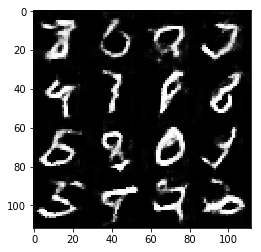

Epoch 2/3... Discriminator Loss: 1.1457... Generator Loss: 1.0336
Epoch 2/3... Discriminator Loss: 1.0880... Generator Loss: 1.3218
Epoch 2/3... Discriminator Loss: 0.9936... Generator Loss: 1.0286
Epoch 2/3... Discriminator Loss: 1.0643... Generator Loss: 1.5870
Epoch 2/3... Discriminator Loss: 1.0428... Generator Loss: 1.2728
Epoch 2/3... Discriminator Loss: 0.9509... Generator Loss: 1.7363
Epoch 2/3... Discriminator Loss: 0.9200... Generator Loss: 1.7159
Epoch 2/3... Discriminator Loss: 1.0765... Generator Loss: 1.5023
Epoch 2/3... Discriminator Loss: 1.0592... Generator Loss: 1.3105
Epoch 2/3... Discriminator Loss: 0.8504... Generator Loss: 1.5457


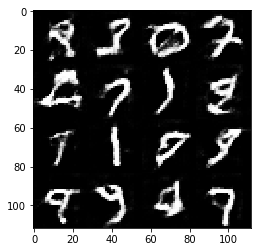

Epoch 2/3... Discriminator Loss: 1.2153... Generator Loss: 1.6916
Epoch 2/3... Discriminator Loss: 1.0410... Generator Loss: 1.4420
Epoch 2/3... Discriminator Loss: 1.0252... Generator Loss: 1.3499
Epoch 2/3... Discriminator Loss: 1.1499... Generator Loss: 1.4418
Epoch 2/3... Discriminator Loss: 0.9538... Generator Loss: 1.0814
Epoch 2/3... Discriminator Loss: 1.1683... Generator Loss: 1.0332
Epoch 2/3... Discriminator Loss: 1.0788... Generator Loss: 1.5063
Epoch 2/3... Discriminator Loss: 1.1853... Generator Loss: 1.8459
Epoch 2/3... Discriminator Loss: 1.1817... Generator Loss: 0.9003
Epoch 2/3... Discriminator Loss: 0.9361... Generator Loss: 1.2662


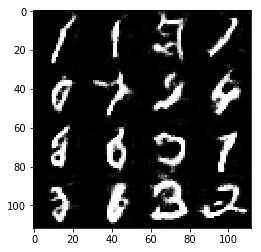

Epoch 2/3... Discriminator Loss: 1.0906... Generator Loss: 0.9460
Epoch 2/3... Discriminator Loss: 1.0749... Generator Loss: 1.4238
Epoch 2/3... Discriminator Loss: 0.9182... Generator Loss: 1.5772
Epoch 2/3... Discriminator Loss: 0.9143... Generator Loss: 1.6004
Epoch 2/3... Discriminator Loss: 1.0388... Generator Loss: 1.3146
Epoch 2/3... Discriminator Loss: 1.0743... Generator Loss: 1.4138
Epoch 2/3... Discriminator Loss: 1.0221... Generator Loss: 1.0576
Epoch 2/3... Discriminator Loss: 1.1792... Generator Loss: 1.6139
Epoch 2/3... Discriminator Loss: 0.9309... Generator Loss: 1.0894
Epoch 2/3... Discriminator Loss: 0.9878... Generator Loss: 1.1352


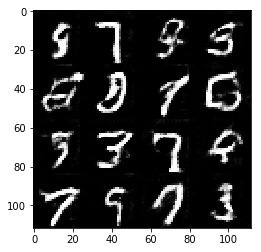

Epoch 2/3... Discriminator Loss: 1.0504... Generator Loss: 1.0096
Epoch 2/3... Discriminator Loss: 0.9511... Generator Loss: 1.2373
Epoch 2/3... Discriminator Loss: 1.1153... Generator Loss: 1.0459
Epoch 2/3... Discriminator Loss: 1.1208... Generator Loss: 1.2923
Epoch 2/3... Discriminator Loss: 0.9526... Generator Loss: 1.3080
Epoch 2/3... Discriminator Loss: 0.9385... Generator Loss: 1.2687
Epoch 2/3... Discriminator Loss: 0.9846... Generator Loss: 1.0735
Epoch 2/3... Discriminator Loss: 1.0419... Generator Loss: 1.2439
Epoch 2/3... Discriminator Loss: 1.0596... Generator Loss: 1.2036
Epoch 2/3... Discriminator Loss: 1.0005... Generator Loss: 1.1902


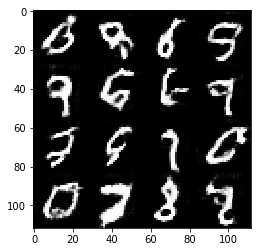

Epoch 2/3... Discriminator Loss: 1.1950... Generator Loss: 1.5679
Epoch 2/3... Discriminator Loss: 0.9720... Generator Loss: 1.1568
Epoch 2/3... Discriminator Loss: 0.8916... Generator Loss: 1.4611
Epoch 2/3... Discriminator Loss: 1.1071... Generator Loss: 1.1338
Epoch 2/3... Discriminator Loss: 1.1533... Generator Loss: 1.7327
Epoch 2/3... Discriminator Loss: 1.0089... Generator Loss: 1.3475
Epoch 2/3... Discriminator Loss: 1.0999... Generator Loss: 1.9702
Epoch 3/3... Discriminator Loss: 0.9731... Generator Loss: 1.0460
Epoch 3/3... Discriminator Loss: 1.1794... Generator Loss: 2.1778
Epoch 3/3... Discriminator Loss: 0.9745... Generator Loss: 1.7833


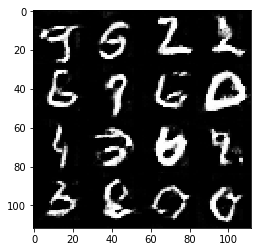

Epoch 3/3... Discriminator Loss: 1.1078... Generator Loss: 1.0071
Epoch 3/3... Discriminator Loss: 1.1083... Generator Loss: 0.9023
Epoch 3/3... Discriminator Loss: 0.9115... Generator Loss: 1.5178
Epoch 3/3... Discriminator Loss: 0.9913... Generator Loss: 1.5993
Epoch 3/3... Discriminator Loss: 1.0136... Generator Loss: 1.1707
Epoch 3/3... Discriminator Loss: 0.8335... Generator Loss: 1.6378
Epoch 3/3... Discriminator Loss: 0.8628... Generator Loss: 1.3352
Epoch 3/3... Discriminator Loss: 1.1501... Generator Loss: 0.9328
Epoch 3/3... Discriminator Loss: 1.1886... Generator Loss: 0.7706
Epoch 3/3... Discriminator Loss: 1.1709... Generator Loss: 1.4189


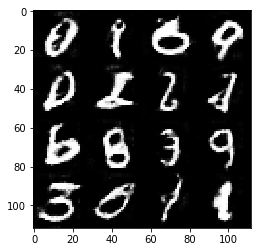

Epoch 3/3... Discriminator Loss: 1.2660... Generator Loss: 0.8201
Epoch 3/3... Discriminator Loss: 1.0463... Generator Loss: 1.0849
Epoch 3/3... Discriminator Loss: 0.9874... Generator Loss: 1.3903
Epoch 3/3... Discriminator Loss: 1.0395... Generator Loss: 1.6108
Epoch 3/3... Discriminator Loss: 0.9720... Generator Loss: 1.1766
Epoch 3/3... Discriminator Loss: 1.0468... Generator Loss: 1.1433
Epoch 3/3... Discriminator Loss: 1.2371... Generator Loss: 0.7803
Epoch 3/3... Discriminator Loss: 0.8779... Generator Loss: 1.5013
Epoch 3/3... Discriminator Loss: 0.9033... Generator Loss: 1.6948
Epoch 3/3... Discriminator Loss: 0.9808... Generator Loss: 1.2362


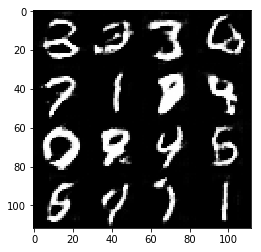

Epoch 3/3... Discriminator Loss: 1.0582... Generator Loss: 1.3962
Epoch 3/3... Discriminator Loss: 0.9464... Generator Loss: 1.1117
Epoch 3/3... Discriminator Loss: 0.8546... Generator Loss: 1.6565
Epoch 3/3... Discriminator Loss: 1.0857... Generator Loss: 1.6939
Epoch 3/3... Discriminator Loss: 1.4165... Generator Loss: 0.6489
Epoch 3/3... Discriminator Loss: 1.0019... Generator Loss: 1.4881
Epoch 3/3... Discriminator Loss: 0.8943... Generator Loss: 1.0554
Epoch 3/3... Discriminator Loss: 1.4307... Generator Loss: 0.8524
Epoch 3/3... Discriminator Loss: 1.0384... Generator Loss: 1.7425
Epoch 3/3... Discriminator Loss: 1.1114... Generator Loss: 1.4753


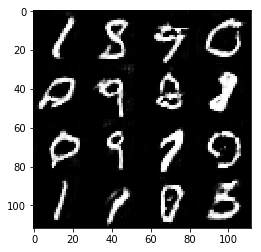

Epoch 3/3... Discriminator Loss: 1.0392... Generator Loss: 1.1607
Epoch 3/3... Discriminator Loss: 0.9441... Generator Loss: 1.2412
Epoch 3/3... Discriminator Loss: 0.8618... Generator Loss: 1.2382
Epoch 3/3... Discriminator Loss: 0.9210... Generator Loss: 1.3664
Epoch 3/3... Discriminator Loss: 0.8928... Generator Loss: 1.4502
Epoch 3/3... Discriminator Loss: 0.9435... Generator Loss: 1.0757
Epoch 3/3... Discriminator Loss: 1.0067... Generator Loss: 1.2934
Epoch 3/3... Discriminator Loss: 1.0931... Generator Loss: 1.2907
Epoch 3/3... Discriminator Loss: 0.9907... Generator Loss: 1.4135
Epoch 3/3... Discriminator Loss: 0.8558... Generator Loss: 1.9397


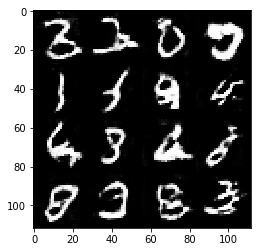

Epoch 3/3... Discriminator Loss: 1.0156... Generator Loss: 1.5953
Epoch 3/3... Discriminator Loss: 0.9302... Generator Loss: 1.1697
Epoch 3/3... Discriminator Loss: 0.9606... Generator Loss: 1.2928
Epoch 3/3... Discriminator Loss: 0.9490... Generator Loss: 1.7735
Epoch 3/3... Discriminator Loss: 0.9928... Generator Loss: 1.6296
Epoch 3/3... Discriminator Loss: 0.9154... Generator Loss: 1.1647
Epoch 3/3... Discriminator Loss: 1.0170... Generator Loss: 1.2574
Epoch 3/3... Discriminator Loss: 0.9211... Generator Loss: 1.1870
Epoch 3/3... Discriminator Loss: 0.9972... Generator Loss: 1.2960
Epoch 3/3... Discriminator Loss: 0.9327... Generator Loss: 1.2868


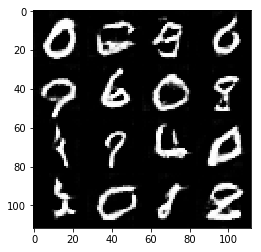

Epoch 3/3... Discriminator Loss: 0.9865... Generator Loss: 1.4460
Epoch 3/3... Discriminator Loss: 0.9592... Generator Loss: 1.6400
Epoch 3/3... Discriminator Loss: 1.1616... Generator Loss: 1.7519
Epoch 3/3... Discriminator Loss: 0.9798... Generator Loss: 1.3036
Epoch 3/3... Discriminator Loss: 0.9533... Generator Loss: 1.1838
Epoch 3/3... Discriminator Loss: 0.8675... Generator Loss: 1.3298
Epoch 3/3... Discriminator Loss: 0.9367... Generator Loss: 1.3038
Epoch 3/3... Discriminator Loss: 0.8707... Generator Loss: 1.5088
Epoch 3/3... Discriminator Loss: 1.8279... Generator Loss: 2.6799
Epoch 3/3... Discriminator Loss: 1.0335... Generator Loss: 1.1949


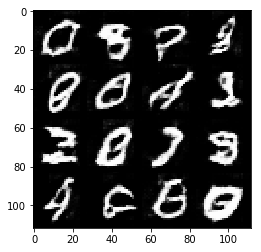

Epoch 3/3... Discriminator Loss: 0.9087... Generator Loss: 1.3324
Epoch 3/3... Discriminator Loss: 0.8406... Generator Loss: 1.5423
Epoch 3/3... Discriminator Loss: 0.8258... Generator Loss: 1.9144
Epoch 3/3... Discriminator Loss: 0.9605... Generator Loss: 1.2405
Epoch 3/3... Discriminator Loss: 0.9960... Generator Loss: 1.4013
Epoch 3/3... Discriminator Loss: 0.9646... Generator Loss: 1.4981
Epoch 3/3... Discriminator Loss: 0.9419... Generator Loss: 1.4452
Epoch 3/3... Discriminator Loss: 0.9934... Generator Loss: 1.6330
Epoch 3/3... Discriminator Loss: 0.8119... Generator Loss: 1.6557
Epoch 3/3... Discriminator Loss: 0.9209... Generator Loss: 1.2379


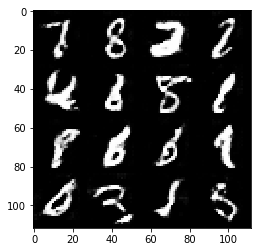

Epoch 3/3... Discriminator Loss: 0.8858... Generator Loss: 1.8723
Epoch 3/3... Discriminator Loss: 1.0315... Generator Loss: 1.1925
Epoch 3/3... Discriminator Loss: 1.0118... Generator Loss: 1.2190
Epoch 3/3... Discriminator Loss: 1.0016... Generator Loss: 1.1208
Epoch 3/3... Discriminator Loss: 1.0108... Generator Loss: 1.3658
Epoch 3/3... Discriminator Loss: 0.9024... Generator Loss: 1.7174
Epoch 3/3... Discriminator Loss: 0.8220... Generator Loss: 1.8379
Epoch 3/3... Discriminator Loss: 0.9460... Generator Loss: 1.5095
Epoch 3/3... Discriminator Loss: 0.9589... Generator Loss: 1.8338
Epoch 3/3... Discriminator Loss: 0.9470... Generator Loss: 1.5306


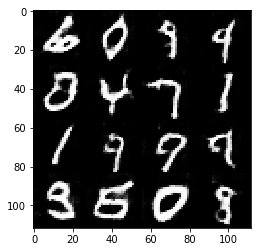

Epoch 3/3... Discriminator Loss: 1.0798... Generator Loss: 0.9544
Epoch 3/3... Discriminator Loss: 1.0737... Generator Loss: 1.2721
Epoch 3/3... Discriminator Loss: 0.8391... Generator Loss: 1.5782
Epoch 3/3... Discriminator Loss: 0.8499... Generator Loss: 1.6028
Epoch 3/3... Discriminator Loss: 0.8237... Generator Loss: 1.7401
Epoch 3/3... Discriminator Loss: 0.9950... Generator Loss: 1.6696
Epoch 3/3... Discriminator Loss: 0.9392... Generator Loss: 1.2837
Epoch 3/3... Discriminator Loss: 0.9465... Generator Loss: 0.9909
Epoch 3/3... Discriminator Loss: 0.8988... Generator Loss: 1.3384
Epoch 3/3... Discriminator Loss: 0.8620... Generator Loss: 1.1946


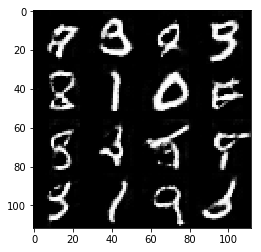

Epoch 3/3... Discriminator Loss: 0.8875... Generator Loss: 1.6889


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.4939... Generator Loss: 3.0687
Epoch 1/2... Discriminator Loss: 0.6795... Generator Loss: 1.5421
Epoch 1/2... Discriminator Loss: 0.5317... Generator Loss: 3.2127
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 4.6662
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.4901
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.9407
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.5088
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 2.2171
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 2.1467


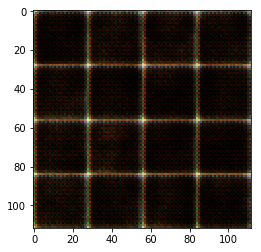

Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 1.3208
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 1.0777
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.8310
Epoch 1/2... Discriminator Loss: 0.8082... Generator Loss: 1.7247
Epoch 1/2... Discriminator Loss: 0.8924... Generator Loss: 2.1166
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 2.9086
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 1.1990


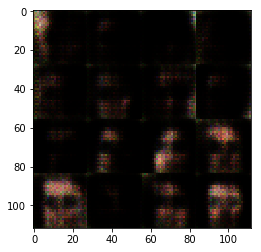

Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 1.4448
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.2303
Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 1.7832
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 1.2492
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 1.0423
Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.7495
Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 2.2917
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.9754


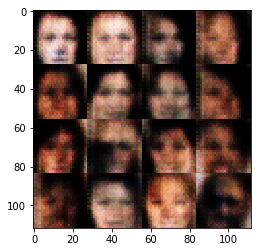

Epoch 1/2... Discriminator Loss: 0.9126... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 3.1324
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 1.9753
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 1.7291
Epoch 1/2... Discriminator Loss: 0.9077... Generator Loss: 1.3512
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.1868
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 2.4733
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.1617
Epoch 1/2... Discriminator Loss: 1.5045... Generator Loss: 3.6526
Epoch 1/2... Discriminator Loss: 1.5988... Generator Loss: 0.4808


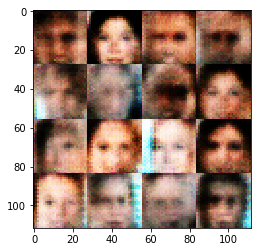

Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 2.0531
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 3.7442
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.9456
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 0.8413... Generator Loss: 1.3840


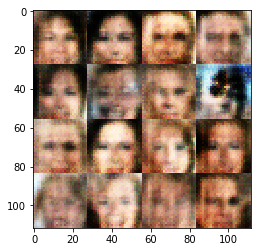

Epoch 1/2... Discriminator Loss: 1.6481... Generator Loss: 0.3765
Epoch 1/2... Discriminator Loss: 1.6514... Generator Loss: 0.4328
Epoch 1/2... Discriminator Loss: 1.6580... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 1.1623
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 0.9223
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.7363
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 1.4337
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 1.1569
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.9002


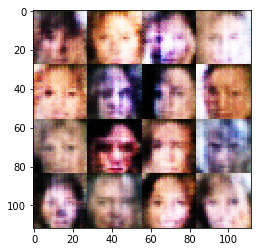

Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 0.8799
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 1.3231
Epoch 1/2... Discriminator Loss: 1.5299... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 0.9972
Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 1.0125


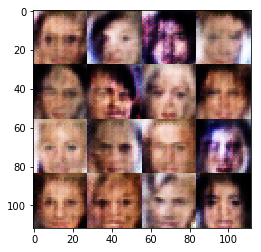

Epoch 1/2... Discriminator Loss: 0.8825... Generator Loss: 1.2941
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.3961
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.7311
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 1.3796
Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 1.7407
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 3.2211
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 1.1910


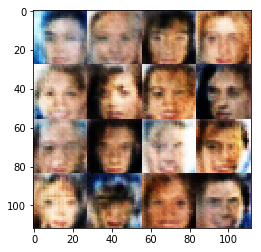

Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 1.3602
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.9699... Generator Loss: 0.2555
Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 0.5989
Epoch 1/2... Discriminator Loss: 0.7430... Generator Loss: 1.5682
Epoch 1/2... Discriminator Loss: 0.6536... Generator Loss: 3.0080
Epoch 1/2... Discriminator Loss: 0.7426... Generator Loss: 1.5132


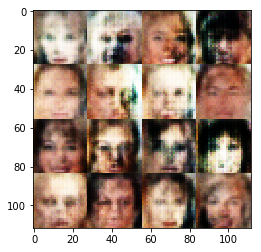

Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 2.0051
Epoch 1/2... Discriminator Loss: 0.5626... Generator Loss: 1.7806
Epoch 1/2... Discriminator Loss: 0.4126... Generator Loss: 3.5678
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.0029
Epoch 1/2... Discriminator Loss: 0.6812... Generator Loss: 1.6924
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 1.4711
Epoch 1/2... Discriminator Loss: 0.5487... Generator Loss: 2.3803
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 2.2656


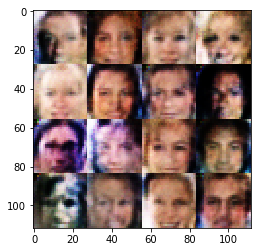

Epoch 1/2... Discriminator Loss: 1.5737... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 0.4896... Generator Loss: 2.5823
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 3.4659
Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 1.9787
Epoch 1/2... Discriminator Loss: 0.6263... Generator Loss: 1.8950
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 3.2112
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 3.7626
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 2.6979
Epoch 1/2... Discriminator Loss: 0.4443... Generator Loss: 3.3326
Epoch 1/2... Discriminator Loss: 0.4234... Generator Loss: 3.0971


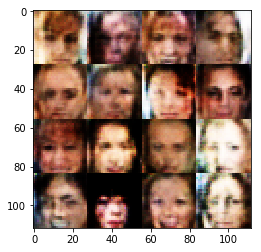

Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 2.1743
Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 3.8985
Epoch 1/2... Discriminator Loss: 1.7184... Generator Loss: 0.3778
Epoch 1/2... Discriminator Loss: 0.6826... Generator Loss: 1.7853
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 2.8163
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.5689
Epoch 1/2... Discriminator Loss: 0.3680... Generator Loss: 5.6543
Epoch 1/2... Discriminator Loss: 0.5690... Generator Loss: 2.8812
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.5246


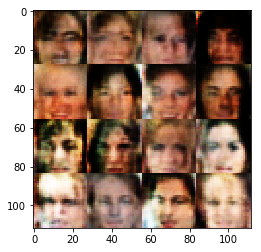

Epoch 1/2... Discriminator Loss: 0.5812... Generator Loss: 3.2154
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 1.2042
Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 2.7677
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 3.0685
Epoch 1/2... Discriminator Loss: 0.5864... Generator Loss: 2.2912
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 1.7588
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 4.5525
Epoch 1/2... Discriminator Loss: 0.5708... Generator Loss: 2.1887
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 0.7418... Generator Loss: 1.6096


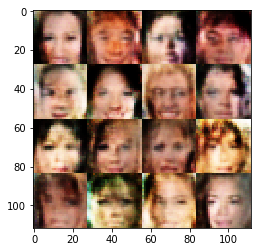

Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 3.4673
Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 4.1575
Epoch 1/2... Discriminator Loss: 0.5128... Generator Loss: 3.2159
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 2.9945
Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 0.5270
Epoch 1/2... Discriminator Loss: 0.4798... Generator Loss: 3.1698
Epoch 1/2... Discriminator Loss: 0.4896... Generator Loss: 3.5991
Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 2.0261
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.6308


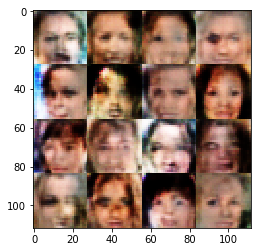

Epoch 1/2... Discriminator Loss: 0.8448... Generator Loss: 1.2930
Epoch 1/2... Discriminator Loss: 0.9093... Generator Loss: 0.9784
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 2.8884
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 3.0080
Epoch 1/2... Discriminator Loss: 0.5947... Generator Loss: 2.0986
Epoch 1/2... Discriminator Loss: 0.4877... Generator Loss: 3.4763
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 3.2229


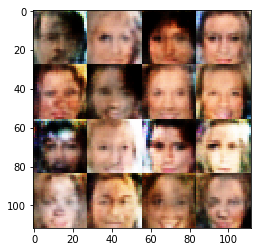

Epoch 1/2... Discriminator Loss: 0.4640... Generator Loss: 2.8353
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 2.1263
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 1.5674
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 2.8832
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 1.6671
Epoch 1/2... Discriminator Loss: 0.4913... Generator Loss: 2.5452
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 3.3482
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 4.9524
Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 2.5980
Epoch 1/2... Discriminator Loss: 0.5832... Generator Loss: 2.3985


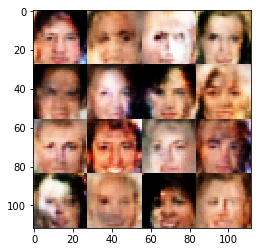

Epoch 1/2... Discriminator Loss: 0.4833... Generator Loss: 2.7038
Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 0.8620... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 0.3897... Generator Loss: 4.4545
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 3.3284
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 3.8720
Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 2.6873
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 2.3097
Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 2.0226
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 1.8580


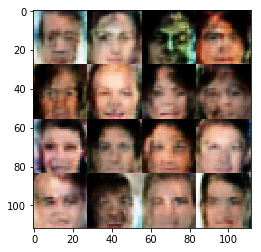

Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 2.0868
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 2.1781
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.9039
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.4978
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 2.7876
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 1.6216
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 2.4618
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 2.6889
Epoch 1/2... Discriminator Loss: 0.7613... Generator Loss: 2.7061


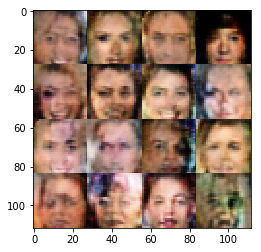

Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.2754
Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 1.7905
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.5256
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 1.4067
Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 1.8322
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 1.3863
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 1.5927
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 1.2866


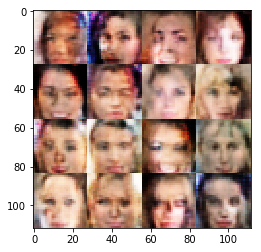

Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 2.3433
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 1.6549
Epoch 1/2... Discriminator Loss: 2.9796... Generator Loss: 0.0999
Epoch 1/2... Discriminator Loss: 1.1932... Generator Loss: 1.1317
Epoch 1/2... Discriminator Loss: 0.8887... Generator Loss: 1.2597
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.5473
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 0.8089


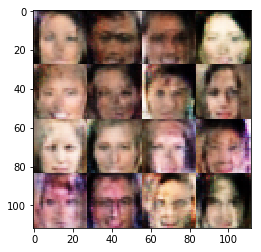

Epoch 1/2... Discriminator Loss: 0.5600... Generator Loss: 2.3253
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 2.1886
Epoch 1/2... Discriminator Loss: 0.7381... Generator Loss: 2.0088
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.5841
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 2.2736
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 0.4706... Generator Loss: 3.4244
Epoch 1/2... Discriminator Loss: 0.5174... Generator Loss: 3.1110
Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 1.8303
Epoch 1/2... Discriminator Loss: 0.6588... Generator Loss: 1.4586


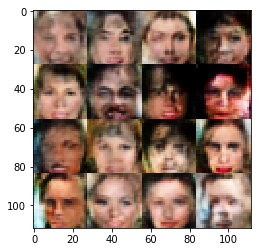

Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 2.5703
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 0.8121... Generator Loss: 1.6932
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 2.1124
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 1.4103
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.7545
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.4362
Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 2.7302
Epoch 1/2... Discriminator Loss: 0.6698... Generator Loss: 1.6568
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.6013


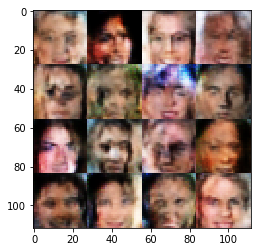

Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 1.7548
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 1.8105
Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 2.6998
Epoch 1/2... Discriminator Loss: 0.5676... Generator Loss: 2.5719
Epoch 1/2... Discriminator Loss: 0.6162... Generator Loss: 3.0019
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 2.5246
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 1.9191
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 2.1883
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 3.6910
Epoch 1/2... Discriminator Loss: 0.8050... Generator Loss: 2.1393


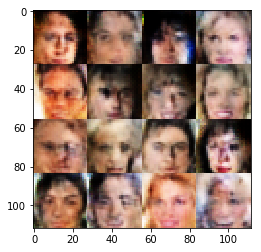

Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.4546
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 2.8381
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 2.0850
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 1.0194
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 2.3323
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 0.5392... Generator Loss: 1.7927
Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 1.4402
Epoch 1/2... Discriminator Loss: 0.5532... Generator Loss: 2.2585


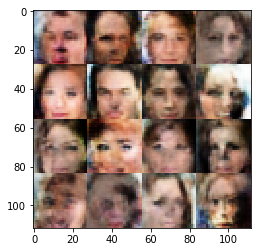

Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 1.3659
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 2.1484
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 1.8900
Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 0.7261... Generator Loss: 1.6538
Epoch 1/2... Discriminator Loss: 0.6760... Generator Loss: 1.7375
Epoch 1/2... Discriminator Loss: 0.6766... Generator Loss: 2.1641
Epoch 1/2... Discriminator Loss: 0.5949... Generator Loss: 2.2640
Epoch 1/2... Discriminator Loss: 0.4902... Generator Loss: 2.7178
Epoch 1/2... Discriminator Loss: 0.4719... Generator Loss: 3.2103


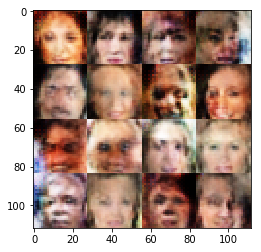

Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 1.8568
Epoch 1/2... Discriminator Loss: 0.9779... Generator Loss: 2.9373
Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.6469
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.4782
Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 2.4222
Epoch 1/2... Discriminator Loss: 0.6076... Generator Loss: 2.9431
Epoch 1/2... Discriminator Loss: 0.6850... Generator Loss: 2.9359
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 2.2118
Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 1.8205


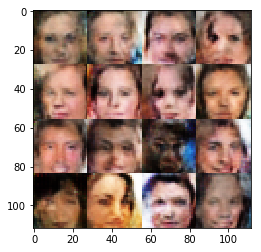

Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.7930
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 1.2172
Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 4.4305
Epoch 1/2... Discriminator Loss: 0.5536... Generator Loss: 2.4734
Epoch 1/2... Discriminator Loss: 0.6463... Generator Loss: 1.6697
Epoch 1/2... Discriminator Loss: 0.7188... Generator Loss: 2.5296
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.7054
Epoch 1/2... Discriminator Loss: 2.2688... Generator Loss: 0.2515
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.2589
Epoch 1/2... Discriminator Loss: 0.6082... Generator Loss: 2.0975


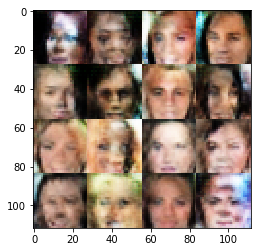

Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.1057
Epoch 1/2... Discriminator Loss: 0.5281... Generator Loss: 3.2783
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.4378
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.3124
Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 1.6986
Epoch 1/2... Discriminator Loss: 0.4934... Generator Loss: 2.2052
Epoch 1/2... Discriminator Loss: 0.4819... Generator Loss: 3.9595
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 0.4735... Generator Loss: 2.8291


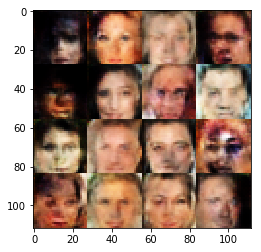

Epoch 1/2... Discriminator Loss: 0.4563... Generator Loss: 3.5083
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.5109
Epoch 1/2... Discriminator Loss: 0.6154... Generator Loss: 3.7298
Epoch 1/2... Discriminator Loss: 0.7381... Generator Loss: 1.3643
Epoch 1/2... Discriminator Loss: 0.5581... Generator Loss: 2.0226
Epoch 1/2... Discriminator Loss: 0.6077... Generator Loss: 2.1274
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 0.4427... Generator Loss: 3.3491
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.5501
Epoch 1/2... Discriminator Loss: 0.8192... Generator Loss: 1.3110


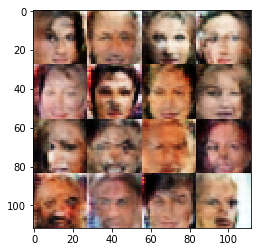

Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.9346
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 2.1505
Epoch 1/2... Discriminator Loss: 0.6558... Generator Loss: 1.8285
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 1.9995
Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 1.8613
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 2.0219
Epoch 1/2... Discriminator Loss: 0.6077... Generator Loss: 1.8394
Epoch 1/2... Discriminator Loss: 0.5940... Generator Loss: 2.3498
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 1.4785
Epoch 1/2... Discriminator Loss: 0.4339... Generator Loss: 3.7850


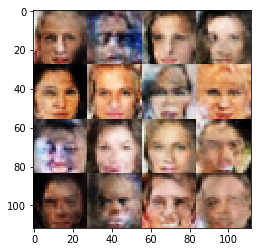

Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 3.1534
Epoch 1/2... Discriminator Loss: 0.5545... Generator Loss: 2.6071
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 2.8145
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.3143
Epoch 1/2... Discriminator Loss: 0.8602... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 1.2160
Epoch 1/2... Discriminator Loss: 0.4610... Generator Loss: 2.7360
Epoch 1/2... Discriminator Loss: 0.7959... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 1.8081... Generator Loss: 3.8556
Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 2.4706


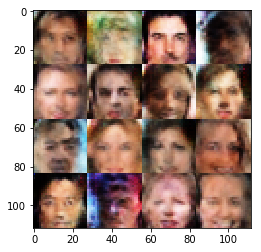

Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 1.7109
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 2.2299
Epoch 1/2... Discriminator Loss: 0.4953... Generator Loss: 2.8031
Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 2.4762
Epoch 1/2... Discriminator Loss: 0.4493... Generator Loss: 3.1408
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 1.8134
Epoch 1/2... Discriminator Loss: 0.4426... Generator Loss: 4.1959
Epoch 1/2... Discriminator Loss: 0.5958... Generator Loss: 2.1982
Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 3.4431
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 1.4725


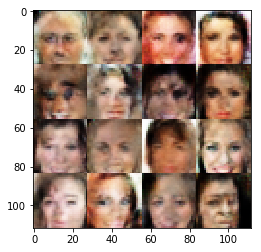

Epoch 1/2... Discriminator Loss: 0.4891... Generator Loss: 3.1139
Epoch 1/2... Discriminator Loss: 0.5922... Generator Loss: 2.3043
Epoch 1/2... Discriminator Loss: 0.5956... Generator Loss: 1.9004
Epoch 1/2... Discriminator Loss: 0.4642... Generator Loss: 3.6099
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 0.9687
Epoch 1/2... Discriminator Loss: 5.4980... Generator Loss: 7.2034
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 1.5031
Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 2.0401
Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 2.3208


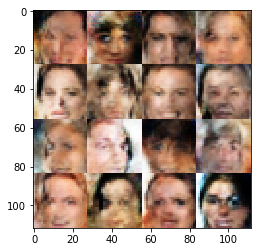

Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 0.9400
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 3.3411
Epoch 1/2... Discriminator Loss: 3.0580... Generator Loss: 0.1880
Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 1.7449
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.7622
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 2.7974
Epoch 1/2... Discriminator Loss: 0.4797... Generator Loss: 2.9110
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 2.7268
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.4458


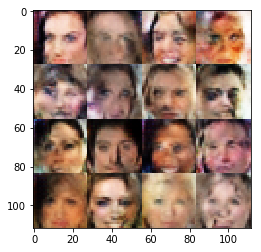

Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 2.7197
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 1.2966
Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 1.8129
Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 2.2582
Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 2.5009
Epoch 1/2... Discriminator Loss: 0.4534... Generator Loss: 3.2157
Epoch 1/2... Discriminator Loss: 0.4791... Generator Loss: 3.2049
Epoch 1/2... Discriminator Loss: 0.5237... Generator Loss: 2.9823
Epoch 1/2... Discriminator Loss: 0.7848... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 2.8360


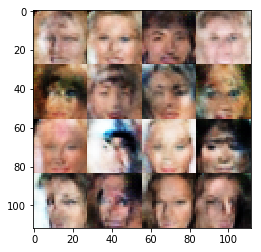

Epoch 1/2... Discriminator Loss: 0.4854... Generator Loss: 2.5740
Epoch 1/2... Discriminator Loss: 0.4303... Generator Loss: 3.9898
Epoch 1/2... Discriminator Loss: 0.4834... Generator Loss: 2.7213
Epoch 1/2... Discriminator Loss: 0.5637... Generator Loss: 2.0449
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 3.4468
Epoch 1/2... Discriminator Loss: 0.8005... Generator Loss: 1.3654
Epoch 1/2... Discriminator Loss: 0.5495... Generator Loss: 1.9650
Epoch 1/2... Discriminator Loss: 0.6219... Generator Loss: 1.6861
Epoch 1/2... Discriminator Loss: 0.5694... Generator Loss: 2.0028
Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 3.1485


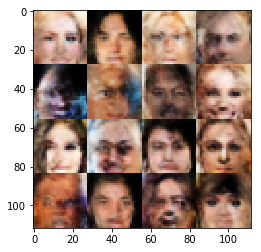

Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 0.6685... Generator Loss: 1.5953
Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 2.9986
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 4.4116
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 2.7322
Epoch 1/2... Discriminator Loss: 0.4512... Generator Loss: 2.9846
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 2.9682
Epoch 1/2... Discriminator Loss: 1.8079... Generator Loss: 4.3287
Epoch 1/2... Discriminator Loss: 0.5853... Generator Loss: 2.2247
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 0.8586


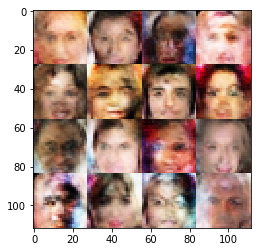

Epoch 1/2... Discriminator Loss: 0.4131... Generator Loss: 3.6451
Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 1.9730
Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 2.3517
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 2.2893
Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 2.5441
Epoch 1/2... Discriminator Loss: 0.7040... Generator Loss: 1.5190
Epoch 1/2... Discriminator Loss: 0.4513... Generator Loss: 2.9158
Epoch 1/2... Discriminator Loss: 0.5274... Generator Loss: 2.7926
Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 1.9712
Epoch 1/2... Discriminator Loss: 0.5787... Generator Loss: 2.1036


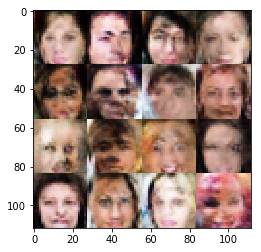

Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 2.5303
Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 4.3503
Epoch 1/2... Discriminator Loss: 0.5573... Generator Loss: 2.3251
Epoch 1/2... Discriminator Loss: 0.5357... Generator Loss: 2.3163
Epoch 1/2... Discriminator Loss: 0.5466... Generator Loss: 2.6465
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 1.5347... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.8151
Epoch 1/2... Discriminator Loss: 0.4778... Generator Loss: 3.0034
Epoch 1/2... Discriminator Loss: 0.6585... Generator Loss: 2.0566


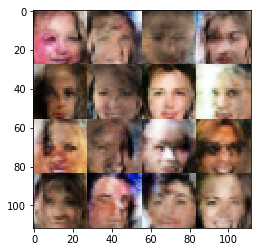

Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 2.0705
Epoch 1/2... Discriminator Loss: 0.5362... Generator Loss: 2.2601
Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 3.2477
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 3.2372
Epoch 1/2... Discriminator Loss: 0.5038... Generator Loss: 2.6211
Epoch 1/2... Discriminator Loss: 0.5699... Generator Loss: 2.8224
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.0777
Epoch 1/2... Discriminator Loss: 1.8498... Generator Loss: 3.4044
Epoch 1/2... Discriminator Loss: 0.4395... Generator Loss: 2.6734
Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 3.0116


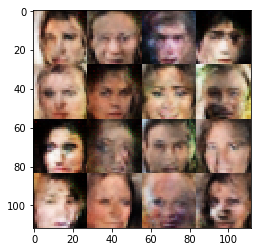

Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 1.9962
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 2.3795
Epoch 1/2... Discriminator Loss: 0.6188... Generator Loss: 2.0909
Epoch 1/2... Discriminator Loss: 0.4719... Generator Loss: 2.3520
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 1.2983
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.3983
Epoch 1/2... Discriminator Loss: 0.4052... Generator Loss: 4.4034
Epoch 1/2... Discriminator Loss: 0.5497... Generator Loss: 2.2562


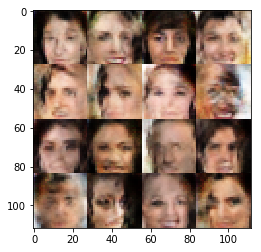

Epoch 1/2... Discriminator Loss: 0.5244... Generator Loss: 2.7471
Epoch 1/2... Discriminator Loss: 0.6288... Generator Loss: 2.3520
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.6822
Epoch 1/2... Discriminator Loss: 0.4948... Generator Loss: 2.1488
Epoch 1/2... Discriminator Loss: 0.5012... Generator Loss: 2.4791
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.6955
Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 2.0637
Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 1.2082
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 3.4431
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 2.9477


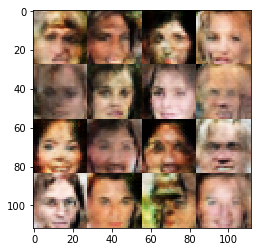

Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.1244
Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 3.4153
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 2.5080
Epoch 1/2... Discriminator Loss: 0.7817... Generator Loss: 3.4663
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 2.1854
Epoch 1/2... Discriminator Loss: 0.4831... Generator Loss: 3.7988
Epoch 1/2... Discriminator Loss: 0.6021... Generator Loss: 2.2063
Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 1.5900
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 2.8428
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.5881


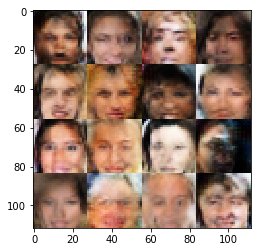

Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 1.8960
Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 1.3685
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 1.1069
Epoch 1/2... Discriminator Loss: 0.6104... Generator Loss: 2.1572
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.6590
Epoch 1/2... Discriminator Loss: 0.6752... Generator Loss: 1.8843
Epoch 1/2... Discriminator Loss: 0.6741... Generator Loss: 2.0667
Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 3.1778
Epoch 1/2... Discriminator Loss: 0.5572... Generator Loss: 2.3237


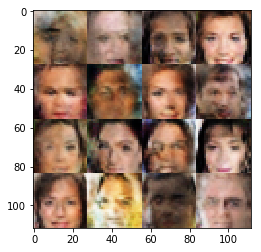

Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 2.0652
Epoch 1/2... Discriminator Loss: 0.4966... Generator Loss: 3.3435
Epoch 1/2... Discriminator Loss: 0.5105... Generator Loss: 2.4381
Epoch 1/2... Discriminator Loss: 0.5237... Generator Loss: 2.4601
Epoch 1/2... Discriminator Loss: 0.5019... Generator Loss: 2.2603
Epoch 1/2... Discriminator Loss: 0.7253... Generator Loss: 2.2287
Epoch 1/2... Discriminator Loss: 0.4569... Generator Loss: 3.3430
Epoch 1/2... Discriminator Loss: 0.5326... Generator Loss: 1.9230
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 1.7184
Epoch 1/2... Discriminator Loss: 0.7633... Generator Loss: 2.0543


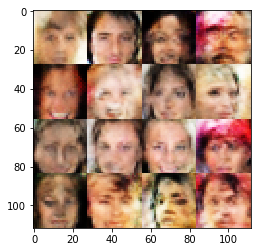

Epoch 1/2... Discriminator Loss: 0.5695... Generator Loss: 1.6754
Epoch 1/2... Discriminator Loss: 0.4943... Generator Loss: 1.8785
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 1.6717
Epoch 1/2... Discriminator Loss: 0.4732... Generator Loss: 2.1631
Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 3.4678
Epoch 1/2... Discriminator Loss: 0.5925... Generator Loss: 1.8542
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 2.9285
Epoch 1/2... Discriminator Loss: 0.6174... Generator Loss: 2.7149
Epoch 1/2... Discriminator Loss: 0.5745... Generator Loss: 1.9405
Epoch 1/2... Discriminator Loss: 2.2822... Generator Loss: 3.8610


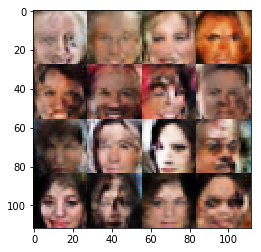

Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.2730
Epoch 1/2... Discriminator Loss: 0.4016... Generator Loss: 3.4960
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 1.5701
Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 1.9397
Epoch 1/2... Discriminator Loss: 0.5574... Generator Loss: 2.1158
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 2.3932
Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 2.4322
Epoch 1/2... Discriminator Loss: 0.4613... Generator Loss: 3.6322
Epoch 1/2... Discriminator Loss: 0.5167... Generator Loss: 2.3942
Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 1.2893


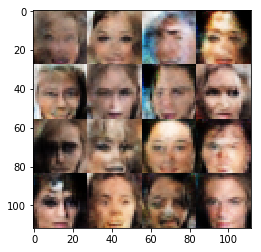

Epoch 1/2... Discriminator Loss: 0.5964... Generator Loss: 2.0652
Epoch 1/2... Discriminator Loss: 0.8110... Generator Loss: 1.3062
Epoch 1/2... Discriminator Loss: 0.4670... Generator Loss: 2.7852
Epoch 1/2... Discriminator Loss: 3.4763... Generator Loss: 5.3246
Epoch 1/2... Discriminator Loss: 0.6653... Generator Loss: 3.0261
Epoch 1/2... Discriminator Loss: 0.7293... Generator Loss: 1.8758
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 1.5957
Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 1.5438
Epoch 1/2... Discriminator Loss: 0.5089... Generator Loss: 2.2312
Epoch 1/2... Discriminator Loss: 0.5212... Generator Loss: 2.4946


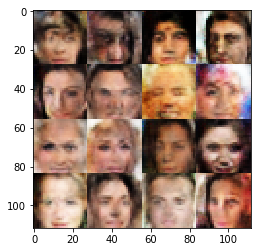

Epoch 1/2... Discriminator Loss: 0.6756... Generator Loss: 2.3106
Epoch 1/2... Discriminator Loss: 0.6327... Generator Loss: 2.4566
Epoch 1/2... Discriminator Loss: 0.5547... Generator Loss: 3.2449
Epoch 1/2... Discriminator Loss: 0.4660... Generator Loss: 2.5472
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 0.6728... Generator Loss: 1.9676
Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 2.5397
Epoch 1/2... Discriminator Loss: 3.1308... Generator Loss: 4.8115
Epoch 1/2... Discriminator Loss: 0.6874... Generator Loss: 2.1195
Epoch 1/2... Discriminator Loss: 0.4941... Generator Loss: 2.0889


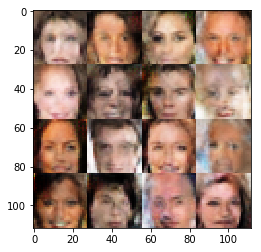

Epoch 1/2... Discriminator Loss: 0.4846... Generator Loss: 2.2321
Epoch 1/2... Discriminator Loss: 0.5245... Generator Loss: 2.2821
Epoch 1/2... Discriminator Loss: 0.4521... Generator Loss: 2.6265
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 1.7597
Epoch 1/2... Discriminator Loss: 0.5322... Generator Loss: 2.2929
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.4752
Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 1.3074
Epoch 1/2... Discriminator Loss: 0.5431... Generator Loss: 2.6598
Epoch 1/2... Discriminator Loss: 0.4660... Generator Loss: 5.5119
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 1.9942


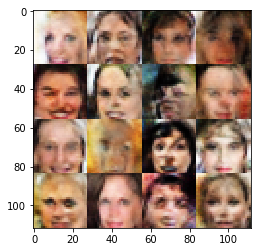

Epoch 1/2... Discriminator Loss: 0.6978... Generator Loss: 3.0564
Epoch 1/2... Discriminator Loss: 0.4787... Generator Loss: 2.5373
Epoch 1/2... Discriminator Loss: 0.5877... Generator Loss: 1.6809
Epoch 1/2... Discriminator Loss: 0.4187... Generator Loss: 3.5025
Epoch 1/2... Discriminator Loss: 0.6881... Generator Loss: 1.5766
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 0.9107
Epoch 1/2... Discriminator Loss: 0.6453... Generator Loss: 2.0071
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 2.0766
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 1.0595


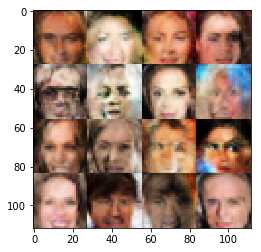

Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 2.9952
Epoch 1/2... Discriminator Loss: 0.4485... Generator Loss: 4.1496
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 2.9560
Epoch 1/2... Discriminator Loss: 2.3615... Generator Loss: 4.3090
Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 0.6762... Generator Loss: 1.4619
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 3.9890
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 2.9083
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 1.6530
Epoch 1/2... Discriminator Loss: 0.4334... Generator Loss: 3.0692


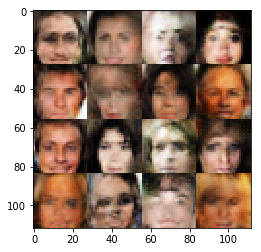

Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 1.5050
Epoch 1/2... Discriminator Loss: 0.4417... Generator Loss: 2.7089
Epoch 1/2... Discriminator Loss: 0.6496... Generator Loss: 2.2297
Epoch 1/2... Discriminator Loss: 0.7087... Generator Loss: 3.2292
Epoch 1/2... Discriminator Loss: 0.4434... Generator Loss: 2.9314
Epoch 1/2... Discriminator Loss: 0.7473... Generator Loss: 2.4783
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 2.6988
Epoch 1/2... Discriminator Loss: 0.5870... Generator Loss: 2.0902
Epoch 1/2... Discriminator Loss: 0.6235... Generator Loss: 1.5683
Epoch 1/2... Discriminator Loss: 0.4499... Generator Loss: 4.5084


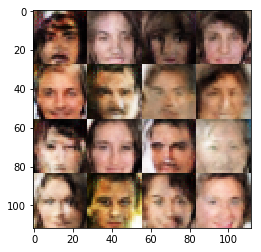

Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.4568
Epoch 1/2... Discriminator Loss: 0.6496... Generator Loss: 1.4242
Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 1.6333
Epoch 1/2... Discriminator Loss: 0.5014... Generator Loss: 4.3086
Epoch 1/2... Discriminator Loss: 0.5694... Generator Loss: 1.8893
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 3.1394
Epoch 1/2... Discriminator Loss: 0.7057... Generator Loss: 2.3296
Epoch 1/2... Discriminator Loss: 0.5706... Generator Loss: 2.7615
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.2732
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.7300


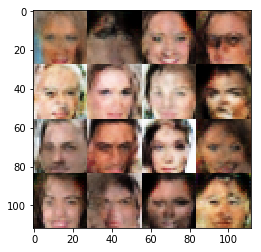

Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 3.3799
Epoch 1/2... Discriminator Loss: 0.5182... Generator Loss: 2.8398
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 2.1732
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.6331
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 1.4294
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 2.5503
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 1.5265
Epoch 1/2... Discriminator Loss: 0.5356... Generator Loss: 2.2520
Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.7022


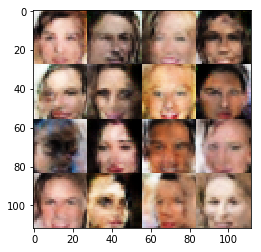

Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 1.3809
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 1.7598
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 3.2215
Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 2.4070
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 4.1981
Epoch 1/2... Discriminator Loss: 0.5121... Generator Loss: 2.3758
Epoch 1/2... Discriminator Loss: 0.6000... Generator Loss: 1.8835
Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 1.7381
Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 2.1960
Epoch 1/2... Discriminator Loss: 0.4842... Generator Loss: 2.7882


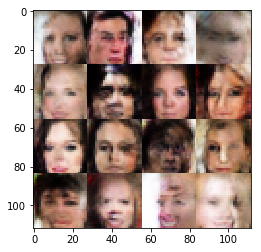

Epoch 1/2... Discriminator Loss: 1.4466... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 0.6722... Generator Loss: 1.7547
Epoch 1/2... Discriminator Loss: 0.5493... Generator Loss: 2.6199
Epoch 1/2... Discriminator Loss: 0.6753... Generator Loss: 1.7655
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.8959
Epoch 1/2... Discriminator Loss: 0.5485... Generator Loss: 2.1845
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 1.9621
Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 2.7572
Epoch 1/2... Discriminator Loss: 0.4423... Generator Loss: 2.9648
Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 3.1902


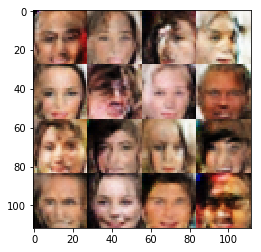

Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.8290
Epoch 1/2... Discriminator Loss: 0.5983... Generator Loss: 3.1255
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 1.9925
Epoch 1/2... Discriminator Loss: 0.5269... Generator Loss: 2.8285
Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 2.9661
Epoch 1/2... Discriminator Loss: 0.6317... Generator Loss: 1.8381
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 1.8544
Epoch 1/2... Discriminator Loss: 0.4606... Generator Loss: 3.0230
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 2.6479
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 1.8930


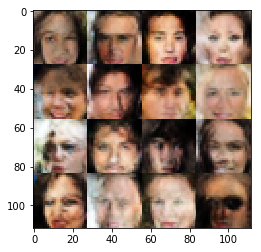

Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 3.4260
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 3.1933
Epoch 1/2... Discriminator Loss: 0.6099... Generator Loss: 1.8116
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 3.5430
Epoch 1/2... Discriminator Loss: 0.6617... Generator Loss: 1.8758
Epoch 1/2... Discriminator Loss: 0.5804... Generator Loss: 2.4276
Epoch 1/2... Discriminator Loss: 0.7049... Generator Loss: 1.1410
Epoch 1/2... Discriminator Loss: 0.6242... Generator Loss: 2.0053
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 2.2080
Epoch 1/2... Discriminator Loss: 0.5842... Generator Loss: 2.0046


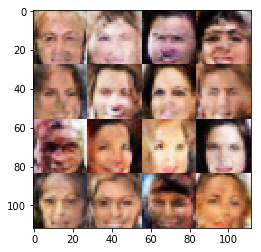

Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 2.2951
Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 3.0140
Epoch 1/2... Discriminator Loss: 0.7603... Generator Loss: 1.8571
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 1.7533
Epoch 1/2... Discriminator Loss: 1.5565... Generator Loss: 0.3753
Epoch 1/2... Discriminator Loss: 2.1663... Generator Loss: 4.2326
Epoch 1/2... Discriminator Loss: 0.4969... Generator Loss: 2.6833
Epoch 1/2... Discriminator Loss: 0.5378... Generator Loss: 2.3917
Epoch 1/2... Discriminator Loss: 0.6256... Generator Loss: 2.3862


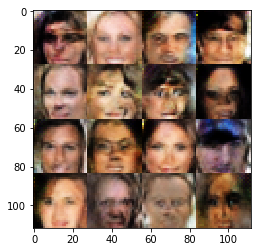

Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.8377
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.5852
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 1.0682
Epoch 1/2... Discriminator Loss: 0.5137... Generator Loss: 2.6719
Epoch 1/2... Discriminator Loss: 0.4557... Generator Loss: 2.3100
Epoch 1/2... Discriminator Loss: 0.5999... Generator Loss: 3.3371
Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 3.3451
Epoch 1/2... Discriminator Loss: 0.4290... Generator Loss: 2.8201
Epoch 1/2... Discriminator Loss: 0.4998... Generator Loss: 2.1521


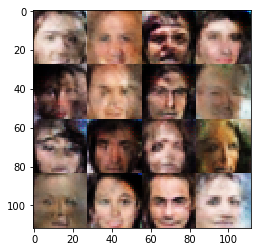

Epoch 1/2... Discriminator Loss: 0.5262... Generator Loss: 2.5492
Epoch 1/2... Discriminator Loss: 0.4368... Generator Loss: 3.2999
Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 1.7558
Epoch 1/2... Discriminator Loss: 0.5097... Generator Loss: 3.0220
Epoch 1/2... Discriminator Loss: 0.6100... Generator Loss: 2.0527
Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 3.8629
Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 2.7345
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 2.3916
Epoch 1/2... Discriminator Loss: 0.4538... Generator Loss: 2.7646
Epoch 1/2... Discriminator Loss: 0.4110... Generator Loss: 4.7556


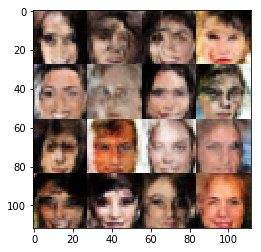

Epoch 1/2... Discriminator Loss: 0.4299... Generator Loss: 2.6321
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 1.3498
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 1.9800
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 1.5640
Epoch 1/2... Discriminator Loss: 0.4933... Generator Loss: 2.8474
Epoch 1/2... Discriminator Loss: 0.6732... Generator Loss: 3.5404
Epoch 1/2... Discriminator Loss: 0.6280... Generator Loss: 2.0290
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 1.7185... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 0.7053... Generator Loss: 2.3220


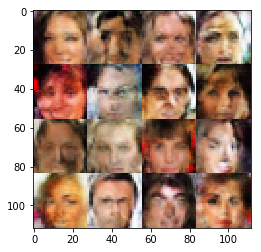

Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.4505
Epoch 1/2... Discriminator Loss: 0.5020... Generator Loss: 2.6165
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 2.0082
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.6051
Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 1.9037
Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 3.5331
Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 2.2589
Epoch 2/2... Discriminator Loss: 0.3992... Generator Loss: 4.3064
Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 2.8057
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 1.6602


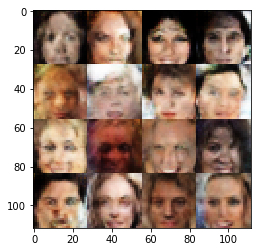

Epoch 2/2... Discriminator Loss: 0.6536... Generator Loss: 1.8276
Epoch 2/2... Discriminator Loss: 0.4226... Generator Loss: 2.6229
Epoch 2/2... Discriminator Loss: 0.3906... Generator Loss: 2.6365
Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 2.6946
Epoch 2/2... Discriminator Loss: 0.6815... Generator Loss: 3.5908
Epoch 2/2... Discriminator Loss: 0.6180... Generator Loss: 2.3653
Epoch 2/2... Discriminator Loss: 0.6136... Generator Loss: 1.5596
Epoch 2/2... Discriminator Loss: 0.5612... Generator Loss: 2.3430
Epoch 2/2... Discriminator Loss: 0.5044... Generator Loss: 2.2115
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.7068


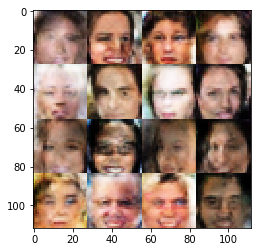

Epoch 2/2... Discriminator Loss: 0.4840... Generator Loss: 2.3481
Epoch 2/2... Discriminator Loss: 0.6241... Generator Loss: 2.3112
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 2.0367
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 2.0532
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 2.6738
Epoch 2/2... Discriminator Loss: 0.4986... Generator Loss: 2.5878
Epoch 2/2... Discriminator Loss: 0.4785... Generator Loss: 3.0324
Epoch 2/2... Discriminator Loss: 0.4946... Generator Loss: 3.3084
Epoch 2/2... Discriminator Loss: 0.4718... Generator Loss: 2.9879
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.1418


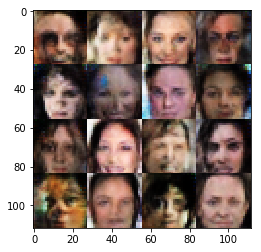

Epoch 2/2... Discriminator Loss: 3.2169... Generator Loss: 5.4133
Epoch 2/2... Discriminator Loss: 0.7909... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 0.6669... Generator Loss: 1.8003
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 0.6382... Generator Loss: 1.6293
Epoch 2/2... Discriminator Loss: 0.4899... Generator Loss: 2.6792
Epoch 2/2... Discriminator Loss: 0.4987... Generator Loss: 2.1496
Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 2.2659
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 2.3824
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 3.1943


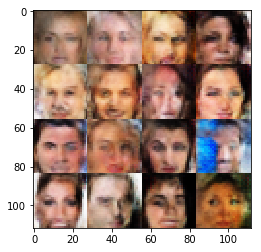

Epoch 2/2... Discriminator Loss: 0.4524... Generator Loss: 3.1702
Epoch 2/2... Discriminator Loss: 0.7016... Generator Loss: 3.8422
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 2.4544
Epoch 2/2... Discriminator Loss: 0.6216... Generator Loss: 2.1309
Epoch 2/2... Discriminator Loss: 0.4279... Generator Loss: 3.3986
Epoch 2/2... Discriminator Loss: 0.5298... Generator Loss: 2.6477
Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 2.7712
Epoch 2/2... Discriminator Loss: 0.5672... Generator Loss: 1.7585
Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 2.6469
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 2.4603


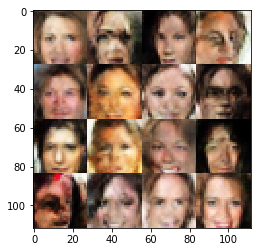

Epoch 2/2... Discriminator Loss: 0.3964... Generator Loss: 4.2412
Epoch 2/2... Discriminator Loss: 0.3777... Generator Loss: 3.9758
Epoch 2/2... Discriminator Loss: 0.7581... Generator Loss: 1.0667
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 3.9172
Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.7668
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 2.0401
Epoch 2/2... Discriminator Loss: 0.5013... Generator Loss: 2.6512
Epoch 2/2... Discriminator Loss: 0.5354... Generator Loss: 2.4358
Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 3.8453
Epoch 2/2... Discriminator Loss: 0.5570... Generator Loss: 2.6255


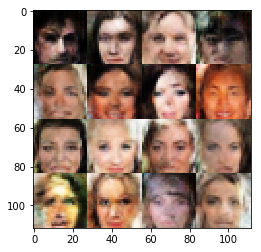

Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.5454
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 1.7019
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 3.0120
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.2197
Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 2.9035
Epoch 2/2... Discriminator Loss: 0.6487... Generator Loss: 1.6458
Epoch 2/2... Discriminator Loss: 0.5184... Generator Loss: 2.5191
Epoch 2/2... Discriminator Loss: 0.6736... Generator Loss: 1.5241
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 3.7208


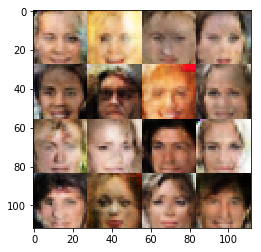

Epoch 2/2... Discriminator Loss: 0.4729... Generator Loss: 3.0990
Epoch 2/2... Discriminator Loss: 0.6608... Generator Loss: 1.6697
Epoch 2/2... Discriminator Loss: 0.4199... Generator Loss: 3.2574
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 3.9701
Epoch 2/2... Discriminator Loss: 0.4823... Generator Loss: 2.5234
Epoch 2/2... Discriminator Loss: 0.5467... Generator Loss: 2.0588
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 1.9505
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 3.3003
Epoch 2/2... Discriminator Loss: 0.5379... Generator Loss: 2.5755
Epoch 2/2... Discriminator Loss: 0.5731... Generator Loss: 2.5144


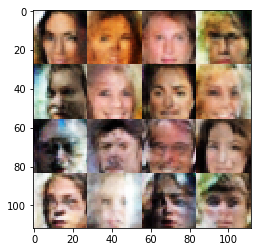

Epoch 2/2... Discriminator Loss: 0.4244... Generator Loss: 3.2428
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 4.8212
Epoch 2/2... Discriminator Loss: 0.7635... Generator Loss: 1.9769
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 2.7406
Epoch 2/2... Discriminator Loss: 0.4899... Generator Loss: 3.9057
Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 2.2478
Epoch 2/2... Discriminator Loss: 1.9658... Generator Loss: 5.3065
Epoch 2/2... Discriminator Loss: 1.4298... Generator Loss: 2.5349
Epoch 2/2... Discriminator Loss: 0.5181... Generator Loss: 2.6528
Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 1.7210


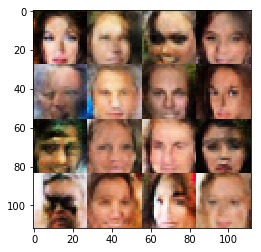

Epoch 2/2... Discriminator Loss: 0.6705... Generator Loss: 2.8976
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 4.3335
Epoch 2/2... Discriminator Loss: 0.6284... Generator Loss: 1.8888
Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 2.5596
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 2.6627
Epoch 2/2... Discriminator Loss: 0.4881... Generator Loss: 3.0838
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 2.6237
Epoch 2/2... Discriminator Loss: 0.4430... Generator Loss: 2.9933
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 2.3808
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 2.3801


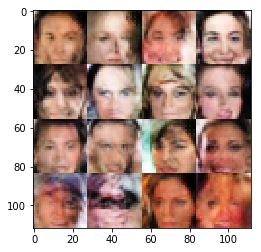

Epoch 2/2... Discriminator Loss: 0.9987... Generator Loss: 0.9416
Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 2.1505
Epoch 2/2... Discriminator Loss: 0.4718... Generator Loss: 2.9012
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 2.7143
Epoch 2/2... Discriminator Loss: 0.5625... Generator Loss: 2.1631
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.8616
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 0.4775... Generator Loss: 2.2451
Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 2.2884
Epoch 2/2... Discriminator Loss: 0.4918... Generator Loss: 1.9559


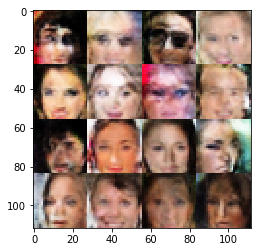

Epoch 2/2... Discriminator Loss: 0.4822... Generator Loss: 3.0059
Epoch 2/2... Discriminator Loss: 0.4854... Generator Loss: 2.6060
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.4041
Epoch 2/2... Discriminator Loss: 0.6104... Generator Loss: 2.5427
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 2.4649
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 2.0832
Epoch 2/2... Discriminator Loss: 0.4693... Generator Loss: 2.4566
Epoch 2/2... Discriminator Loss: 0.6848... Generator Loss: 1.7435
Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 2.1514
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 4.3280


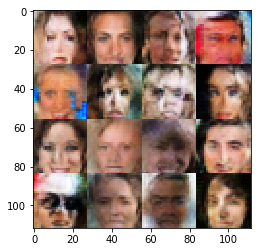

Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.6622
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.5646
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 3.1810
Epoch 2/2... Discriminator Loss: 0.7029... Generator Loss: 1.7509
Epoch 2/2... Discriminator Loss: 0.8163... Generator Loss: 3.1890
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 1.6267
Epoch 2/2... Discriminator Loss: 0.5980... Generator Loss: 2.8687
Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 2.1737
Epoch 2/2... Discriminator Loss: 0.4770... Generator Loss: 2.9963
Epoch 2/2... Discriminator Loss: 0.5564... Generator Loss: 2.1078


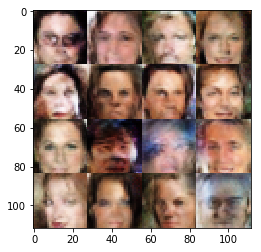

Epoch 2/2... Discriminator Loss: 0.5417... Generator Loss: 2.7598
Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 1.6733
Epoch 2/2... Discriminator Loss: 0.4560... Generator Loss: 2.9864
Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 1.5871
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 1.6033
Epoch 2/2... Discriminator Loss: 0.5349... Generator Loss: 2.6016
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 2.0789
Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 1.9877
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 1.8788
Epoch 2/2... Discriminator Loss: 0.6297... Generator Loss: 1.5266


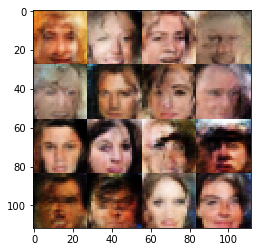

Epoch 2/2... Discriminator Loss: 0.5422... Generator Loss: 2.0666
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 2.0971
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 2.9711
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 2.4850
Epoch 2/2... Discriminator Loss: 0.4958... Generator Loss: 2.7975
Epoch 2/2... Discriminator Loss: 0.6339... Generator Loss: 4.0078
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.9868
Epoch 2/2... Discriminator Loss: 0.5870... Generator Loss: 1.9215
Epoch 2/2... Discriminator Loss: 0.5922... Generator Loss: 2.4430
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 1.7475


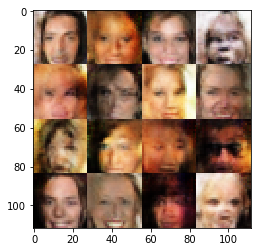

Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 2.9116
Epoch 2/2... Discriminator Loss: 0.5911... Generator Loss: 1.6032
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 1.3741
Epoch 2/2... Discriminator Loss: 0.4063... Generator Loss: 4.1929
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 1.8025
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 1.9179
Epoch 2/2... Discriminator Loss: 0.4744... Generator Loss: 2.7950
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 2.4710
Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 3.9877


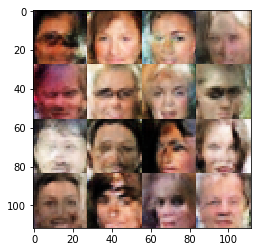

Epoch 2/2... Discriminator Loss: 0.4561... Generator Loss: 2.5717
Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 1.5339
Epoch 2/2... Discriminator Loss: 0.4843... Generator Loss: 2.7505
Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 4.2223
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.8102
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 2.5677
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 4.8035
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 3.2868
Epoch 2/2... Discriminator Loss: 0.5239... Generator Loss: 3.6211
Epoch 2/2... Discriminator Loss: 0.4915... Generator Loss: 2.9592


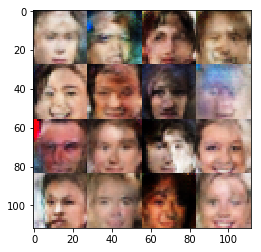

Epoch 2/2... Discriminator Loss: 0.5566... Generator Loss: 2.4972
Epoch 2/2... Discriminator Loss: 0.5752... Generator Loss: 3.1603
Epoch 2/2... Discriminator Loss: 0.5911... Generator Loss: 2.2200
Epoch 2/2... Discriminator Loss: 0.5886... Generator Loss: 2.4284
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 3.1548
Epoch 2/2... Discriminator Loss: 0.6865... Generator Loss: 2.0609
Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 1.9952
Epoch 2/2... Discriminator Loss: 0.5275... Generator Loss: 2.4771
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 0.9304
Epoch 2/2... Discriminator Loss: 0.8628... Generator Loss: 1.3139


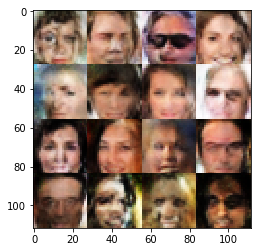

Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 1.1658
Epoch 2/2... Discriminator Loss: 0.8008... Generator Loss: 1.6574
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 2.8522
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 2.5878
Epoch 2/2... Discriminator Loss: 0.5946... Generator Loss: 1.5114
Epoch 2/2... Discriminator Loss: 0.4843... Generator Loss: 2.8882
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 2.2765
Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 2.5246
Epoch 2/2... Discriminator Loss: 0.5050... Generator Loss: 2.9890
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.0994


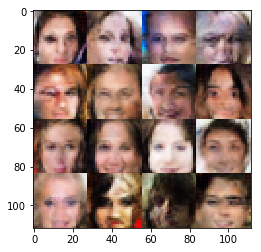

Epoch 2/2... Discriminator Loss: 0.4955... Generator Loss: 3.4238
Epoch 2/2... Discriminator Loss: 1.9088... Generator Loss: 0.2405
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 2.8776
Epoch 2/2... Discriminator Loss: 0.5717... Generator Loss: 2.0764
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.3135
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.7796
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 2.2707
Epoch 2/2... Discriminator Loss: 0.3972... Generator Loss: 3.8898


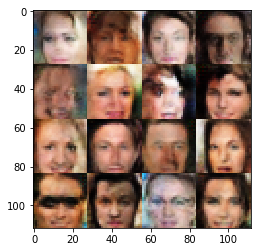

Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 1.2403
Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 2.1526
Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.6898
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 2.7125
Epoch 2/2... Discriminator Loss: 0.6937... Generator Loss: 1.3105
Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 1.3707
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.5694
Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 2.9453
Epoch 2/2... Discriminator Loss: 0.5529... Generator Loss: 2.0681
Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 2.1870


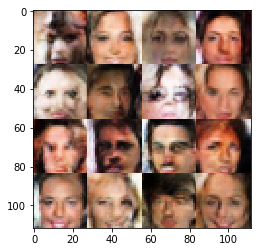

Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 2.3383
Epoch 2/2... Discriminator Loss: 0.5420... Generator Loss: 2.2815
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 3.1645
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 2.9438
Epoch 2/2... Discriminator Loss: 0.8626... Generator Loss: 5.4521
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 3.6676
Epoch 2/2... Discriminator Loss: 0.6323... Generator Loss: 3.1823
Epoch 2/2... Discriminator Loss: 0.6354... Generator Loss: 1.8266
Epoch 2/2... Discriminator Loss: 0.5889... Generator Loss: 2.2817


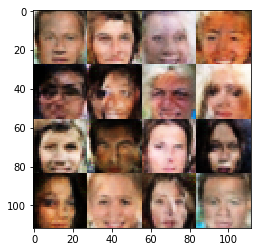

Epoch 2/2... Discriminator Loss: 0.6116... Generator Loss: 2.1447
Epoch 2/2... Discriminator Loss: 1.4695... Generator Loss: 0.8237
Epoch 2/2... Discriminator Loss: 0.4307... Generator Loss: 3.3380
Epoch 2/2... Discriminator Loss: 2.8355... Generator Loss: 0.2946
Epoch 2/2... Discriminator Loss: 0.7635... Generator Loss: 1.5804
Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 2.3079
Epoch 2/2... Discriminator Loss: 0.5840... Generator Loss: 2.4999
Epoch 2/2... Discriminator Loss: 0.5926... Generator Loss: 2.0214
Epoch 2/2... Discriminator Loss: 0.5174... Generator Loss: 2.1649
Epoch 2/2... Discriminator Loss: 0.5982... Generator Loss: 2.7000


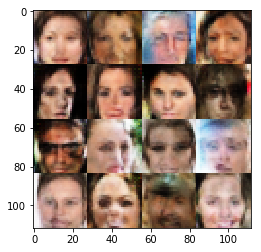

Epoch 2/2... Discriminator Loss: 0.6242... Generator Loss: 2.4951
Epoch 2/2... Discriminator Loss: 0.4852... Generator Loss: 3.0540
Epoch 2/2... Discriminator Loss: 1.3304... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.6286
Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 1.6793
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 2.6062
Epoch 2/2... Discriminator Loss: 0.4990... Generator Loss: 2.1573
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 4.3331
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 2.3573
Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 2.8631


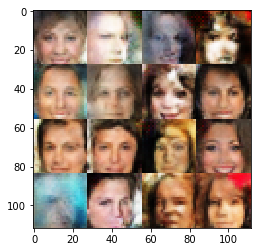

Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 1.4536
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 0.5121... Generator Loss: 3.0521
Epoch 2/2... Discriminator Loss: 1.5377... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 2.6551
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 2.3002
Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 1.6446
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.4409
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 2.3326


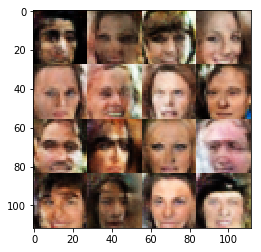

Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 2.5261
Epoch 2/2... Discriminator Loss: 0.4545... Generator Loss: 2.2986
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.7812
Epoch 2/2... Discriminator Loss: 0.6268... Generator Loss: 1.9710
Epoch 2/2... Discriminator Loss: 0.4856... Generator Loss: 2.6133
Epoch 2/2... Discriminator Loss: 0.5489... Generator Loss: 1.4143
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 3.3861
Epoch 2/2... Discriminator Loss: 0.6113... Generator Loss: 2.1222
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 1.2813
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.2246


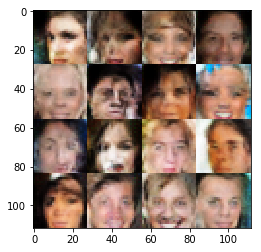

Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.6717
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 2.5604
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 2.8201
Epoch 2/2... Discriminator Loss: 0.6352... Generator Loss: 2.9338
Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 2.2145
Epoch 2/2... Discriminator Loss: 0.4960... Generator Loss: 3.3424
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 2.2581
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 2.3610


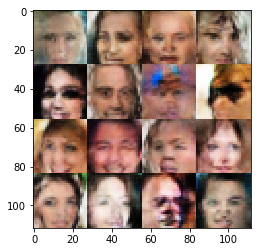

Epoch 2/2... Discriminator Loss: 2.2771... Generator Loss: 4.6633
Epoch 2/2... Discriminator Loss: 0.6280... Generator Loss: 2.1851
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 2.5590
Epoch 2/2... Discriminator Loss: 0.5570... Generator Loss: 2.2684
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.7576... Generator Loss: 1.9362
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 0.9337
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 2.9821
Epoch 2/2... Discriminator Loss: 0.5202... Generator Loss: 2.1033
Epoch 2/2... Discriminator Loss: 0.6787... Generator Loss: 2.2274


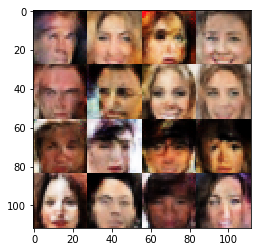

Epoch 2/2... Discriminator Loss: 0.6244... Generator Loss: 1.9023
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.9926
Epoch 2/2... Discriminator Loss: 0.4570... Generator Loss: 2.5596
Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 2.3459
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 1.3701
Epoch 2/2... Discriminator Loss: 0.4049... Generator Loss: 3.0442
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 2.1848
Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 2.1704
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 2.5391
Epoch 2/2... Discriminator Loss: 0.4839... Generator Loss: 2.9795


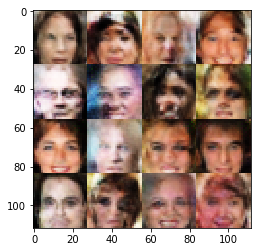

Epoch 2/2... Discriminator Loss: 0.4287... Generator Loss: 4.3735
Epoch 2/2... Discriminator Loss: 0.4798... Generator Loss: 2.7026
Epoch 2/2... Discriminator Loss: 0.5268... Generator Loss: 2.3625
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.8969
Epoch 2/2... Discriminator Loss: 0.5202... Generator Loss: 2.4305
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 1.6228
Epoch 2/2... Discriminator Loss: 0.4379... Generator Loss: 3.4098
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 1.9886
Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 2.7918
Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 2.7840


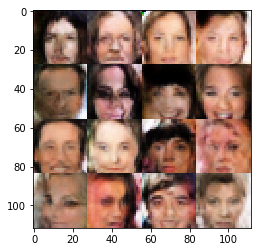

Epoch 2/2... Discriminator Loss: 1.4953... Generator Loss: 2.1251
Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 1.7782
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 2.1200
Epoch 2/2... Discriminator Loss: 0.6340... Generator Loss: 2.0396
Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 4.3872
Epoch 2/2... Discriminator Loss: 0.4606... Generator Loss: 2.9054
Epoch 2/2... Discriminator Loss: 0.5427... Generator Loss: 3.2170
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 4.4802
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 2.0447


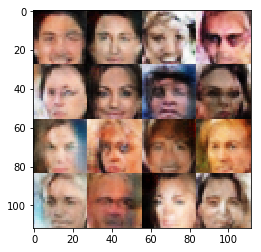

Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 1.7422
Epoch 2/2... Discriminator Loss: 0.5276... Generator Loss: 2.7381
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 2.2377
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.7468
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.7765
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 1.5829
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 3.6691
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 2.7114
Epoch 2/2... Discriminator Loss: 0.4747... Generator Loss: 2.0193
Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 1.1605


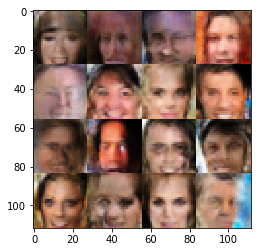

Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 2.4015
Epoch 2/2... Discriminator Loss: 0.5355... Generator Loss: 2.4197
Epoch 2/2... Discriminator Loss: 0.4333... Generator Loss: 3.9327
Epoch 2/2... Discriminator Loss: 0.6087... Generator Loss: 3.6776
Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.5797
Epoch 2/2... Discriminator Loss: 0.6119... Generator Loss: 2.5437
Epoch 2/2... Discriminator Loss: 0.4456... Generator Loss: 2.6380
Epoch 2/2... Discriminator Loss: 0.6394... Generator Loss: 1.3948
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 3.8569
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 1.0137


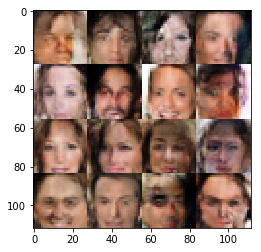

Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 1.0895
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.6425
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 2.1147
Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 2.5779
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 2.0295
Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 2.9445
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 0.7823... Generator Loss: 1.9749
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.7101


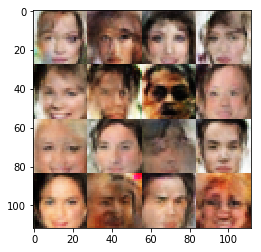

Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 2.8929
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.2698
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 2.1517
Epoch 2/2... Discriminator Loss: 0.5824... Generator Loss: 2.7579
Epoch 2/2... Discriminator Loss: 0.6249... Generator Loss: 2.4020
Epoch 2/2... Discriminator Loss: 0.4792... Generator Loss: 3.5905
Epoch 2/2... Discriminator Loss: 0.5030... Generator Loss: 2.4638
Epoch 2/2... Discriminator Loss: 0.5126... Generator Loss: 2.4445
Epoch 2/2... Discriminator Loss: 0.5976... Generator Loss: 3.0335
Epoch 2/2... Discriminator Loss: 0.5604... Generator Loss: 2.9181


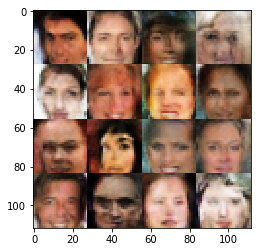

Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 0.5833... Generator Loss: 2.4715
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.8048
Epoch 2/2... Discriminator Loss: 0.4392... Generator Loss: 2.9440
Epoch 2/2... Discriminator Loss: 0.4891... Generator Loss: 2.6231
Epoch 2/2... Discriminator Loss: 1.7664... Generator Loss: 0.6472
Epoch 2/2... Discriminator Loss: 1.7100... Generator Loss: 0.3561
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 1.0068
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 1.2707
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 1.9438


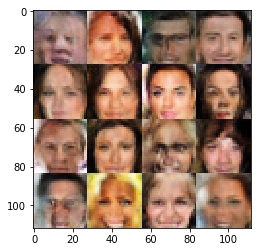

Epoch 2/2... Discriminator Loss: 0.5536... Generator Loss: 2.1161
Epoch 2/2... Discriminator Loss: 0.7281... Generator Loss: 2.1475
Epoch 2/2... Discriminator Loss: 0.4907... Generator Loss: 1.8564
Epoch 2/2... Discriminator Loss: 0.5554... Generator Loss: 2.1694
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 2.6238
Epoch 2/2... Discriminator Loss: 0.4712... Generator Loss: 2.2462
Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.6388
Epoch 2/2... Discriminator Loss: 0.4261... Generator Loss: 4.4493
Epoch 2/2... Discriminator Loss: 0.7016... Generator Loss: 3.5298
Epoch 2/2... Discriminator Loss: 0.6539... Generator Loss: 2.0608


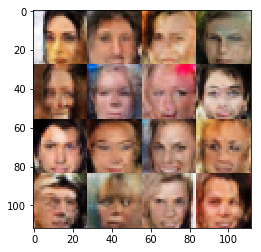

Epoch 2/2... Discriminator Loss: 0.4811... Generator Loss: 4.3870
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 1.9302
Epoch 2/2... Discriminator Loss: 0.5429... Generator Loss: 2.0366
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 2.6317
Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 2.3392
Epoch 2/2... Discriminator Loss: 1.7310... Generator Loss: 3.9555
Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 3.6062
Epoch 2/2... Discriminator Loss: 0.4617... Generator Loss: 3.8965
Epoch 2/2... Discriminator Loss: 0.4971... Generator Loss: 2.5698


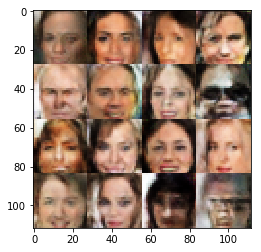

Epoch 2/2... Discriminator Loss: 1.6196... Generator Loss: 0.2989
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 2.0307
Epoch 2/2... Discriminator Loss: 0.5266... Generator Loss: 2.5969
Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 1.6393
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.5956
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 2.3957
Epoch 2/2... Discriminator Loss: 0.6833... Generator Loss: 2.3218
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 1.9260
Epoch 2/2... Discriminator Loss: 0.4768... Generator Loss: 2.8027
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 1.8549


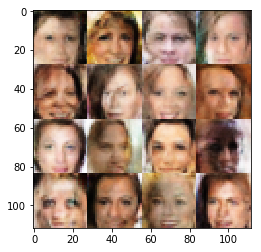

Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 2.2973
Epoch 2/2... Discriminator Loss: 0.5935... Generator Loss: 3.0866
Epoch 2/2... Discriminator Loss: 0.4795... Generator Loss: 2.9705
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 2.5847
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 1.4783
Epoch 2/2... Discriminator Loss: 0.4433... Generator Loss: 3.3660
Epoch 2/2... Discriminator Loss: 0.4675... Generator Loss: 2.4520
Epoch 2/2... Discriminator Loss: 0.6238... Generator Loss: 2.5053
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 2.2949
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 3.7338


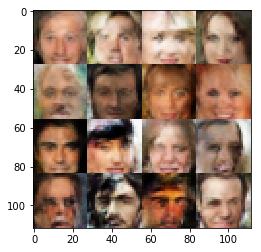

Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 1.8167
Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.5721
Epoch 2/2... Discriminator Loss: 1.5657... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 2.0850
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 3.8123
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.9361
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.8775
Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 1.7122
Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 2.4000


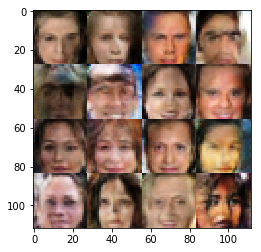

Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 2.3037
Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 3.4885
Epoch 2/2... Discriminator Loss: 0.5800... Generator Loss: 3.0613
Epoch 2/2... Discriminator Loss: 0.6504... Generator Loss: 1.6247
Epoch 2/2... Discriminator Loss: 0.5518... Generator Loss: 2.7204
Epoch 2/2... Discriminator Loss: 0.6728... Generator Loss: 1.5106
Epoch 2/2... Discriminator Loss: 0.4574... Generator Loss: 3.2794
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 1.0711
Epoch 2/2... Discriminator Loss: 0.6003... Generator Loss: 2.3821
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 2.1448


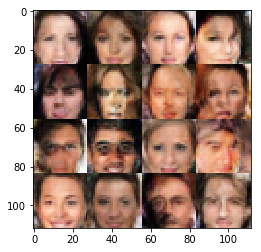

Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.3663
Epoch 2/2... Discriminator Loss: 0.5496... Generator Loss: 2.3069
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 2.3622
Epoch 2/2... Discriminator Loss: 0.5841... Generator Loss: 2.1407
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.5565
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 3.2169
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 4.2256
Epoch 2/2... Discriminator Loss: 0.5699... Generator Loss: 2.1482
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 3.4502
Epoch 2/2... Discriminator Loss: 0.4289... Generator Loss: 3.3549


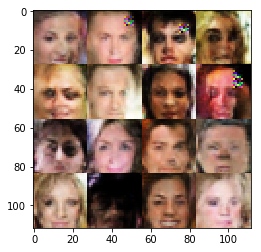

Epoch 2/2... Discriminator Loss: 0.4041... Generator Loss: 4.5033
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 2.0848
Epoch 2/2... Discriminator Loss: 0.4134... Generator Loss: 4.1401
Epoch 2/2... Discriminator Loss: 0.4459... Generator Loss: 2.4565
Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 2.0579
Epoch 2/2... Discriminator Loss: 0.6284... Generator Loss: 2.1981
Epoch 2/2... Discriminator Loss: 0.4677... Generator Loss: 2.4765
Epoch 2/2... Discriminator Loss: 0.4202... Generator Loss: 3.4336
Epoch 2/2... Discriminator Loss: 0.4295... Generator Loss: 3.5300
Epoch 2/2... Discriminator Loss: 0.3894... Generator Loss: 4.0083


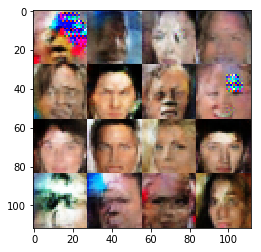

Epoch 2/2... Discriminator Loss: 0.4130... Generator Loss: 3.5543
Epoch 2/2... Discriminator Loss: 0.4061... Generator Loss: 4.1903
Epoch 2/2... Discriminator Loss: 0.4316... Generator Loss: 3.5702
Epoch 2/2... Discriminator Loss: 0.4791... Generator Loss: 4.5482
Epoch 2/2... Discriminator Loss: 0.4317... Generator Loss: 3.5378
Epoch 2/2... Discriminator Loss: 0.4002... Generator Loss: 3.8877
Epoch 2/2... Discriminator Loss: 0.3756... Generator Loss: 4.7097
Epoch 2/2... Discriminator Loss: 0.4178... Generator Loss: 3.5888
Epoch 2/2... Discriminator Loss: 0.4548... Generator Loss: 3.4989
Epoch 2/2... Discriminator Loss: 0.4404... Generator Loss: 1.8147


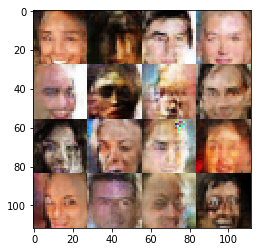

Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 4.6464
Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 5.1226
Epoch 2/2... Discriminator Loss: 0.3789... Generator Loss: 6.2357
Epoch 2/2... Discriminator Loss: 0.3830... Generator Loss: 4.3262
Epoch 2/2... Discriminator Loss: 0.4154... Generator Loss: 4.3383
Epoch 2/2... Discriminator Loss: 0.4123... Generator Loss: 4.0225
Epoch 2/2... Discriminator Loss: 0.3964... Generator Loss: 4.2946
Epoch 2/2... Discriminator Loss: 0.4676... Generator Loss: 3.6489
Epoch 2/2... Discriminator Loss: 0.6411... Generator Loss: 2.8969
Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 1.8011


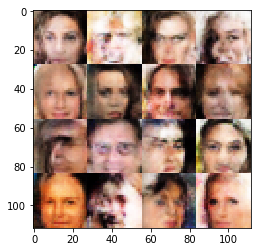

Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 1.8478
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 3.8552
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 2.2396
Epoch 2/2... Discriminator Loss: 0.4943... Generator Loss: 3.0236
Epoch 2/2... Discriminator Loss: 0.5314... Generator Loss: 1.9113
Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 2.2031
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 2.0721
Epoch 2/2... Discriminator Loss: 0.4213... Generator Loss: 2.3067
Epoch 2/2... Discriminator Loss: 0.4715... Generator Loss: 2.7906
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.5700


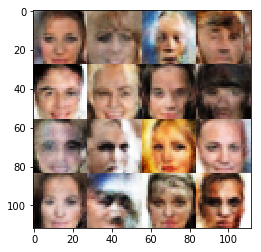

Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 2.1867
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 2.0730
Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 5.6621
Epoch 2/2... Discriminator Loss: 0.5784... Generator Loss: 2.2592
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 2.1343
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 1.3530
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 2.1583
Epoch 2/2... Discriminator Loss: 0.6032... Generator Loss: 2.1951
Epoch 2/2... Discriminator Loss: 0.5659... Generator Loss: 2.3854


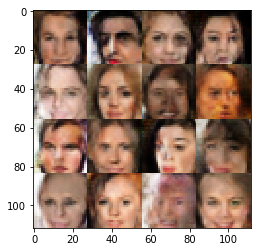

Epoch 2/2... Discriminator Loss: 0.4792... Generator Loss: 2.8654
Epoch 2/2... Discriminator Loss: 0.6752... Generator Loss: 1.9145
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 0.4141... Generator Loss: 4.5265
Epoch 2/2... Discriminator Loss: 2.3703... Generator Loss: 0.4820
Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.6169
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 1.2106
Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 2.9577
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 1.1688
Epoch 2/2... Discriminator Loss: 0.5835... Generator Loss: 2.1768


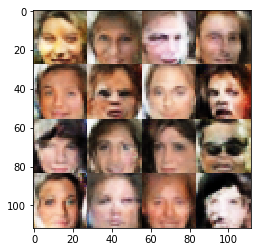

Epoch 2/2... Discriminator Loss: 0.3701... Generator Loss: 4.6393
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 2.4150
Epoch 2/2... Discriminator Loss: 0.4199... Generator Loss: 4.1477
Epoch 2/2... Discriminator Loss: 0.4557... Generator Loss: 2.9890
Epoch 2/2... Discriminator Loss: 0.6099... Generator Loss: 3.1692
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.9996
Epoch 2/2... Discriminator Loss: 0.3870... Generator Loss: 4.3494
Epoch 2/2... Discriminator Loss: 0.5720... Generator Loss: 2.1198
Epoch 2/2... Discriminator Loss: 0.4444... Generator Loss: 4.2911
Epoch 2/2... Discriminator Loss: 0.4152... Generator Loss: 2.6027


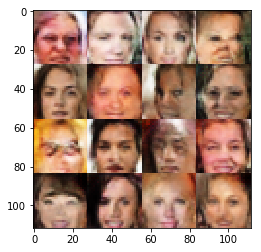

Epoch 2/2... Discriminator Loss: 0.4441... Generator Loss: 4.2113
Epoch 2/2... Discriminator Loss: 0.5448... Generator Loss: 4.1986
Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 3.6152
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 4.5543
Epoch 2/2... Discriminator Loss: 0.4260... Generator Loss: 3.8484
Epoch 2/2... Discriminator Loss: 0.4388... Generator Loss: 4.5128
Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 1.8289
Epoch 2/2... Discriminator Loss: 0.3645... Generator Loss: 5.8049
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 5.1635


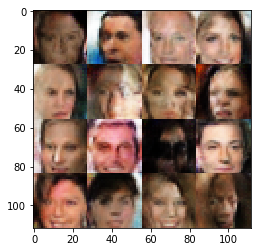

Epoch 2/2... Discriminator Loss: 0.4715... Generator Loss: 2.8970
Epoch 2/2... Discriminator Loss: 2.1729... Generator Loss: 3.5311
Epoch 2/2... Discriminator Loss: 0.3787... Generator Loss: 4.3728
Epoch 2/2... Discriminator Loss: 0.3619... Generator Loss: 6.2152
Epoch 2/2... Discriminator Loss: 0.5672... Generator Loss: 1.3841
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.4646
Epoch 2/2... Discriminator Loss: 0.5562... Generator Loss: 2.4690
Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 2.6786
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.9495
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 4.0870


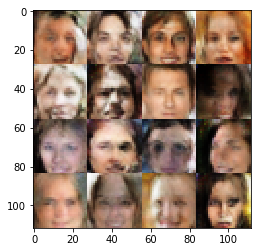

Epoch 2/2... Discriminator Loss: 0.5572... Generator Loss: 3.3700
Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 2.0247
Epoch 2/2... Discriminator Loss: 0.6031... Generator Loss: 2.6199
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 1.7094
Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 2.2601
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 2.8327
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 2.1372
Epoch 2/2... Discriminator Loss: 0.6975... Generator Loss: 1.4414
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 2.5769


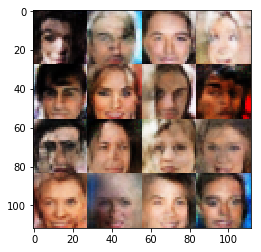

Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 2.2062
Epoch 2/2... Discriminator Loss: 0.5524... Generator Loss: 2.6219
Epoch 2/2... Discriminator Loss: 0.5541... Generator Loss: 2.0385
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 2.4657
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 3.1728
Epoch 2/2... Discriminator Loss: 0.4759... Generator Loss: 3.4264
Epoch 2/2... Discriminator Loss: 0.6606... Generator Loss: 2.2311
Epoch 2/2... Discriminator Loss: 0.4800... Generator Loss: 3.0299
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.9492
Epoch 2/2... Discriminator Loss: 0.7084... Generator Loss: 2.2315


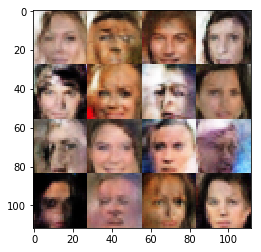

Epoch 2/2... Discriminator Loss: 0.6178... Generator Loss: 2.1024
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 1.1107
Epoch 2/2... Discriminator Loss: 0.5847... Generator Loss: 3.2842
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 4.3232
Epoch 2/2... Discriminator Loss: 0.5031... Generator Loss: 2.5571
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.2174
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 3.2476
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 2.3069
Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.9105
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.5262


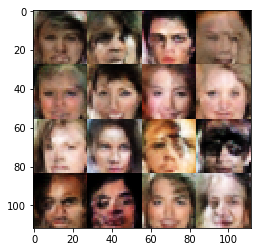

Epoch 2/2... Discriminator Loss: 0.4978... Generator Loss: 2.6446
Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 1.8698
Epoch 2/2... Discriminator Loss: 1.4030... Generator Loss: 0.5455
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 2.1284
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 3.4303
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 2.3771
Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 1.8764
Epoch 2/2... Discriminator Loss: 1.5113... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.6540
Epoch 2/2... Discriminator Loss: 0.4565... Generator Loss: 2.9768


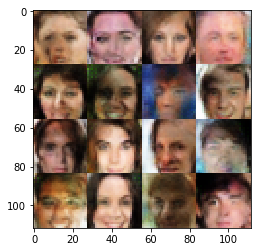

Epoch 2/2... Discriminator Loss: 0.4643... Generator Loss: 2.5069
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 2.4152
Epoch 2/2... Discriminator Loss: 0.9168... Generator Loss: 3.6942
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 0.6305... Generator Loss: 2.4451
Epoch 2/2... Discriminator Loss: 0.4991... Generator Loss: 2.2532
Epoch 2/2... Discriminator Loss: 0.4500... Generator Loss: 3.4453
Epoch 2/2... Discriminator Loss: 0.5720... Generator Loss: 1.4920
Epoch 2/2... Discriminator Loss: 0.4898... Generator Loss: 2.9256
Epoch 2/2... Discriminator Loss: 0.5735... Generator Loss: 3.8828


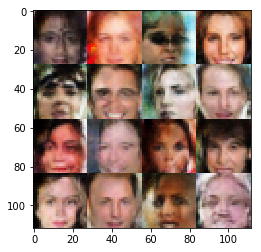

Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 2.6881
Epoch 2/2... Discriminator Loss: 0.6100... Generator Loss: 1.9970
Epoch 2/2... Discriminator Loss: 0.4298... Generator Loss: 4.0411
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 3.9070
Epoch 2/2... Discriminator Loss: 0.6286... Generator Loss: 2.0134
Epoch 2/2... Discriminator Loss: 0.5275... Generator Loss: 2.2680
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 1.5188
Epoch 2/2... Discriminator Loss: 0.4265... Generator Loss: 3.2249
Epoch 2/2... Discriminator Loss: 1.7614... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 1.2646


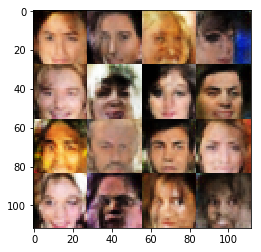

Epoch 2/2... Discriminator Loss: 0.5239... Generator Loss: 2.2370
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 2.9826
Epoch 2/2... Discriminator Loss: 0.5614... Generator Loss: 2.2387
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 2.4403
Epoch 2/2... Discriminator Loss: 0.5352... Generator Loss: 2.9804
Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 2.1388
Epoch 2/2... Discriminator Loss: 0.4322... Generator Loss: 3.5367
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 3.4554
Epoch 2/2... Discriminator Loss: 0.5896... Generator Loss: 3.6232
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 2.7695


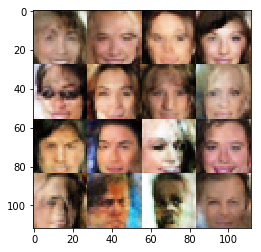

Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 2.3527
Epoch 2/2... Discriminator Loss: 0.4920... Generator Loss: 2.6742
Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 2.2632
Epoch 2/2... Discriminator Loss: 0.4705... Generator Loss: 2.9785
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 1.6494
Epoch 2/2... Discriminator Loss: 0.4437... Generator Loss: 3.8192
Epoch 2/2... Discriminator Loss: 0.4318... Generator Loss: 3.5894
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 2.7279
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 1.4591
Epoch 2/2... Discriminator Loss: 0.6617... Generator Loss: 2.3959


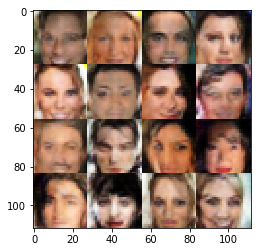

Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 3.1098
Epoch 2/2... Discriminator Loss: 0.5091... Generator Loss: 3.1490
Epoch 2/2... Discriminator Loss: 0.4470... Generator Loss: 3.0739
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 3.1857
Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 2.7738
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 0.4448... Generator Loss: 2.1129
Epoch 2/2... Discriminator Loss: 0.4917... Generator Loss: 3.5059
Epoch 2/2... Discriminator Loss: 2.0697... Generator Loss: 0.1890
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 2.0902


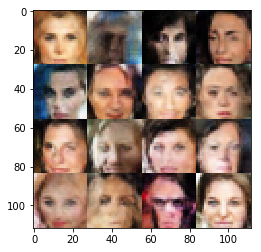

Epoch 2/2... Discriminator Loss: 0.7050... Generator Loss: 1.9461
Epoch 2/2... Discriminator Loss: 0.5237... Generator Loss: 2.0183
Epoch 2/2... Discriminator Loss: 0.6860... Generator Loss: 4.3332
Epoch 2/2... Discriminator Loss: 0.4322... Generator Loss: 4.1697
Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 2.8177
Epoch 2/2... Discriminator Loss: 0.6043... Generator Loss: 2.9554
Epoch 2/2... Discriminator Loss: 0.6564... Generator Loss: 2.8942
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 2.6456
Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 2.6790
Epoch 2/2... Discriminator Loss: 0.5296... Generator Loss: 2.6631


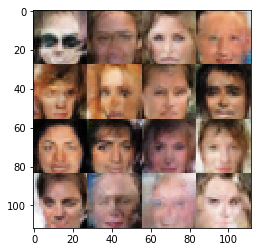

Epoch 2/2... Discriminator Loss: 0.6144... Generator Loss: 2.1599
Epoch 2/2... Discriminator Loss: 0.4599... Generator Loss: 4.2812
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 2.2627
Epoch 2/2... Discriminator Loss: 0.5838... Generator Loss: 4.6175
Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 4.4425
Epoch 2/2... Discriminator Loss: 0.6034... Generator Loss: 1.5030
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.4151
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 2.9277
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.8344
Epoch 2/2... Discriminator Loss: 0.4771... Generator Loss: 2.4750


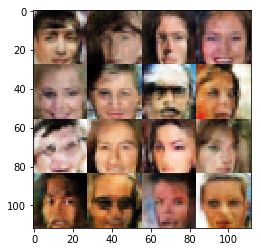

Epoch 2/2... Discriminator Loss: 0.5786... Generator Loss: 2.9561
Epoch 2/2... Discriminator Loss: 0.4840... Generator Loss: 5.1020
Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 3.0161
Epoch 2/2... Discriminator Loss: 0.5219... Generator Loss: 2.4238
Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 3.0237
Epoch 2/2... Discriminator Loss: 0.4142... Generator Loss: 2.8003


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.